In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import warnings
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.svm import SVR

In [3]:
warnings.filterwarnings('ignore')

In [4]:
trains = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
tests = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [5]:
print("Shape of the train dataset:",trains.shape)
print("Shape of the test dataset:",tests.shape)

Shape of the train dataset: (1460, 81)
Shape of the test dataset: (1459, 80)


In [6]:
def load():
    train = pd.concat([trains, tests]).reset_index(drop=True)

    return train

train = load()

In [7]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# **EDA**

In [8]:
def data_type(dataframe, cat_th=10, car_th=25):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    print(num_but_cat)
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car and col != 'PoolArea']

    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat or col == 'PoolArea']
    
    return cat_cols, num_cols, cat_but_car

In [9]:
cat_cols, num_cols, cat_but_car = data_type(train, car_th=25)
print("\n")
print(f"Categorical Columns : {cat_cols}")
print(f"Number of Categorical Columns : {len(cat_cols)}")
print("\n")
print(f"Numerical Columns : {num_cols}")
print(f"Number of Numerical Columns : {len(num_cols)}")
print("\n")
print(f"Cat_But_Car : {cat_but_car}")

['OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'YrSold']


Categorical Columns : ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'YrSold']
Number of Categorical Columns : 53


Numerical Columns : ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQ

In [10]:
num_cols = [col for col in num_cols if col not in ["Id", "SalePrice"]]

print(f"Numerical columns : {num_cols}")

Numerical columns : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold']


In [11]:
for i in cat_cols:
    print(i,":",train[i].dtype)
    value_counts = train[i].value_counts().to_dict()
    for key, value in value_counts.items():
        print(f"{key}: {value}")
    print("\n")

MSZoning : object
RL: 2265
RM: 460
FV: 139
RH: 26
C (all): 25


Street : object
Pave: 2907
Grvl: 12


Alley : object
Grvl: 120
Pave: 78


LotShape : object
Reg: 1859
IR1: 968
IR2: 76
IR3: 16


LandContour : object
Lvl: 2622
HLS: 120
Bnk: 117
Low: 60


Utilities : object
AllPub: 2916
NoSeWa: 1


LotConfig : object
Inside: 2133
Corner: 511
CulDSac: 176
FR2: 85
FR3: 14


LandSlope : object
Gtl: 2778
Mod: 125
Sev: 16


Neighborhood : object
NAmes: 443
CollgCr: 267
OldTown: 239
Edwards: 194
Somerst: 182
NridgHt: 166
Gilbert: 165
Sawyer: 151
NWAmes: 131
SawyerW: 125
Mitchel: 114
BrkSide: 108
Crawfor: 103
IDOTRR: 93
Timber: 72
NoRidge: 71
StoneBr: 51
SWISU: 48
ClearCr: 44
MeadowV: 37
BrDale: 30
Blmngtn: 28
Veenker: 24
NPkVill: 23
Blueste: 10


Condition1 : object
Norm: 2511
Feedr: 164
Artery: 92
RRAn: 50
PosN: 39
RRAe: 28
PosA: 20
RRNn: 9
RRNe: 6


Condition2 : object
Norm: 2889
Feedr: 13
Artery: 5
PosN: 4
PosA: 4
RRNn: 2
RRAn: 1
RRAe: 1


BldgType : object
1Fam: 2425
TwnhsE: 227
Duplex: 109


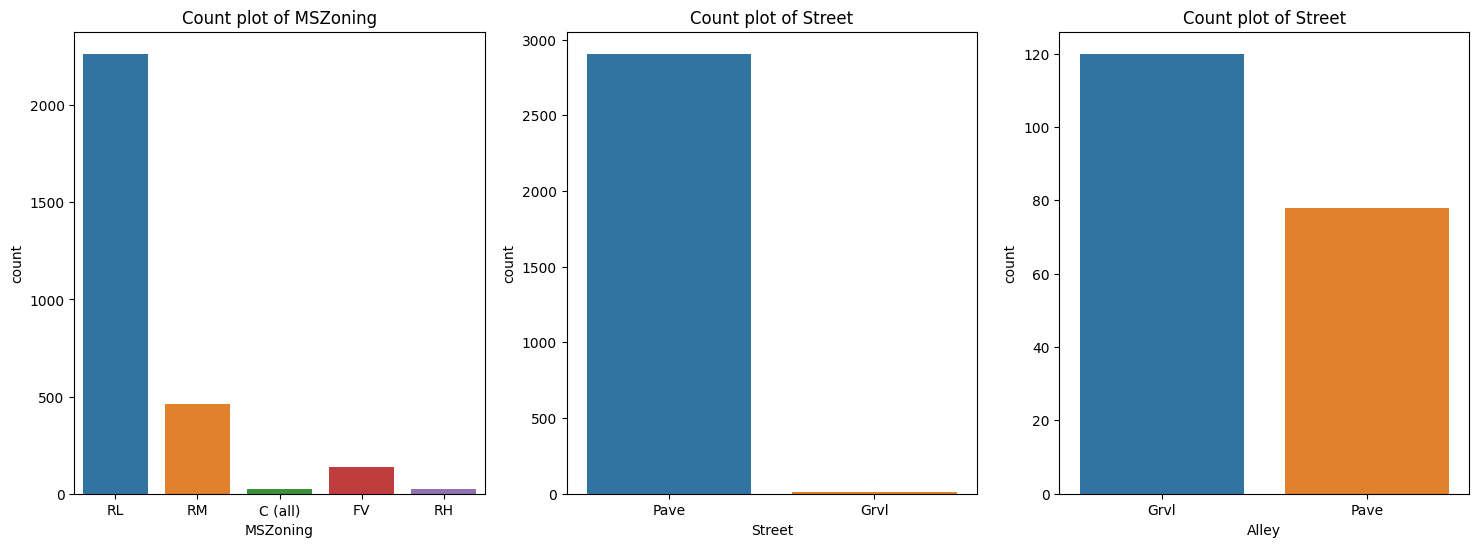

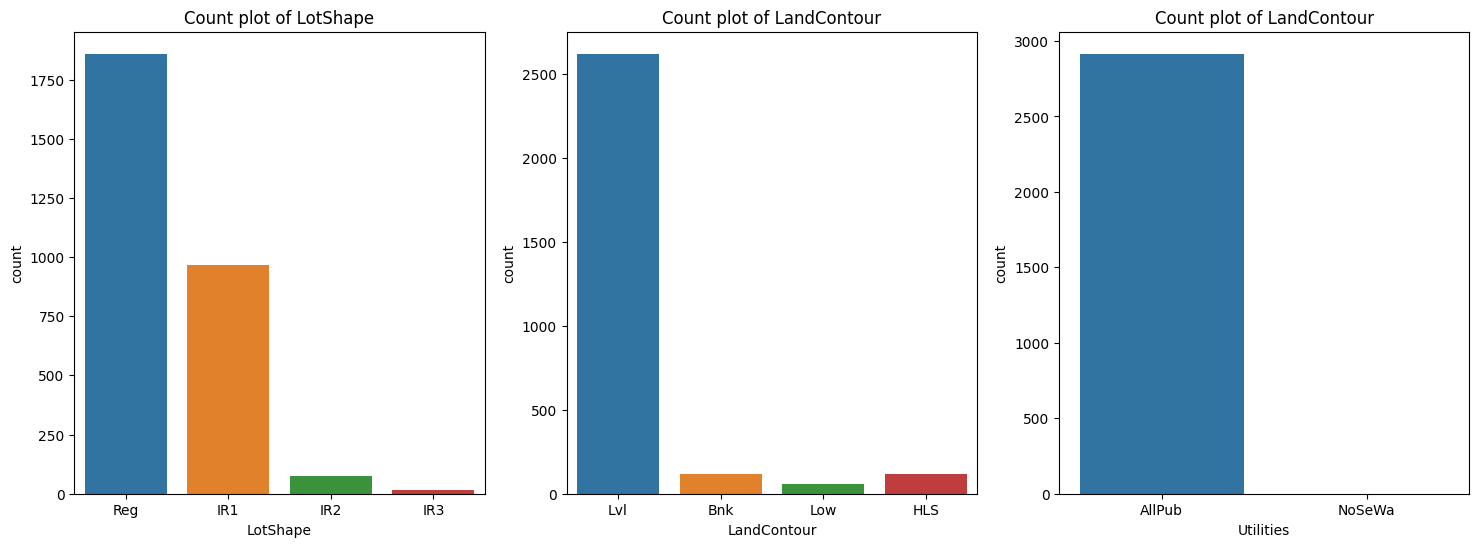

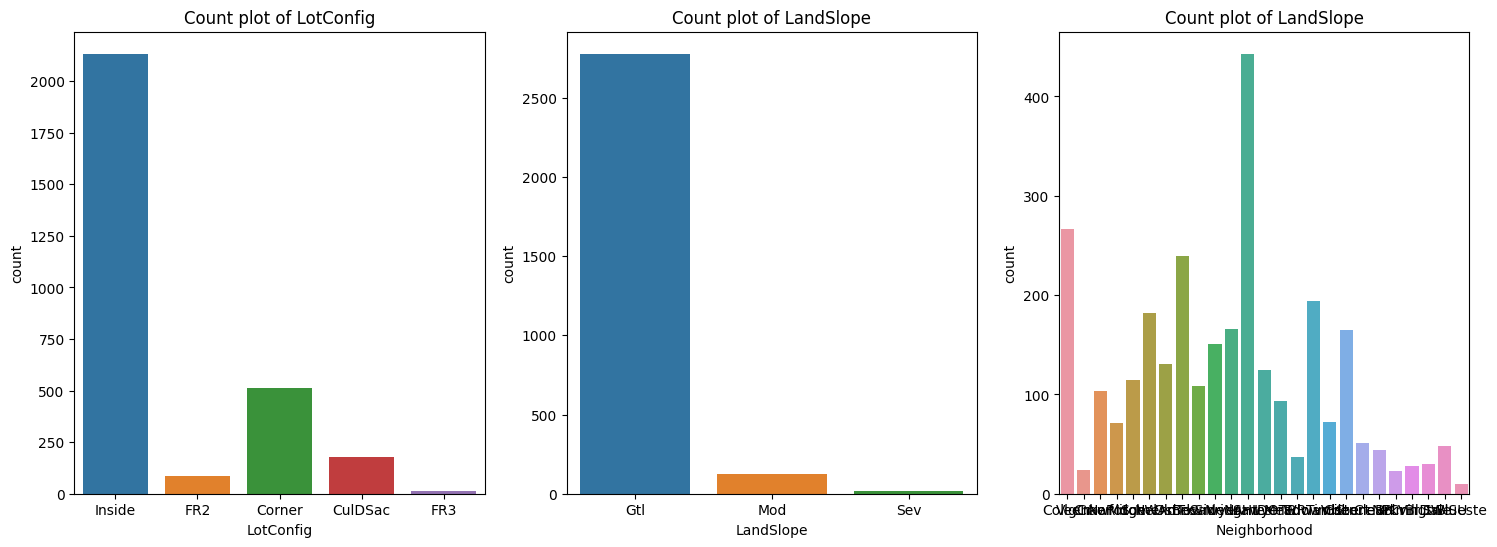

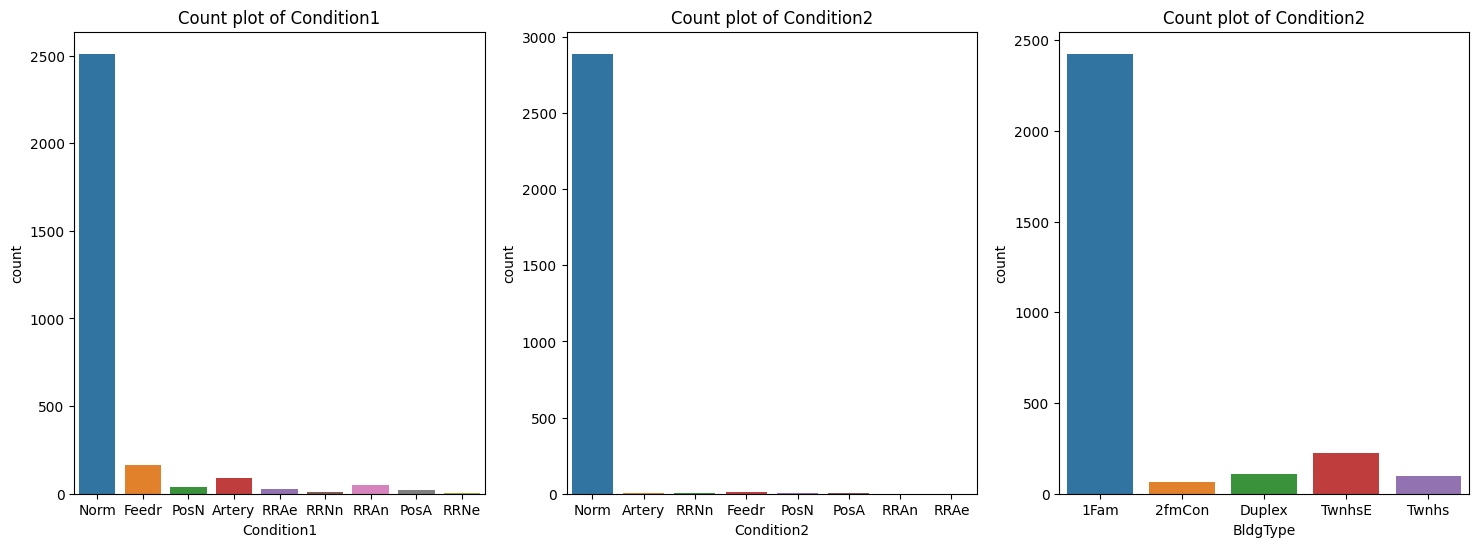

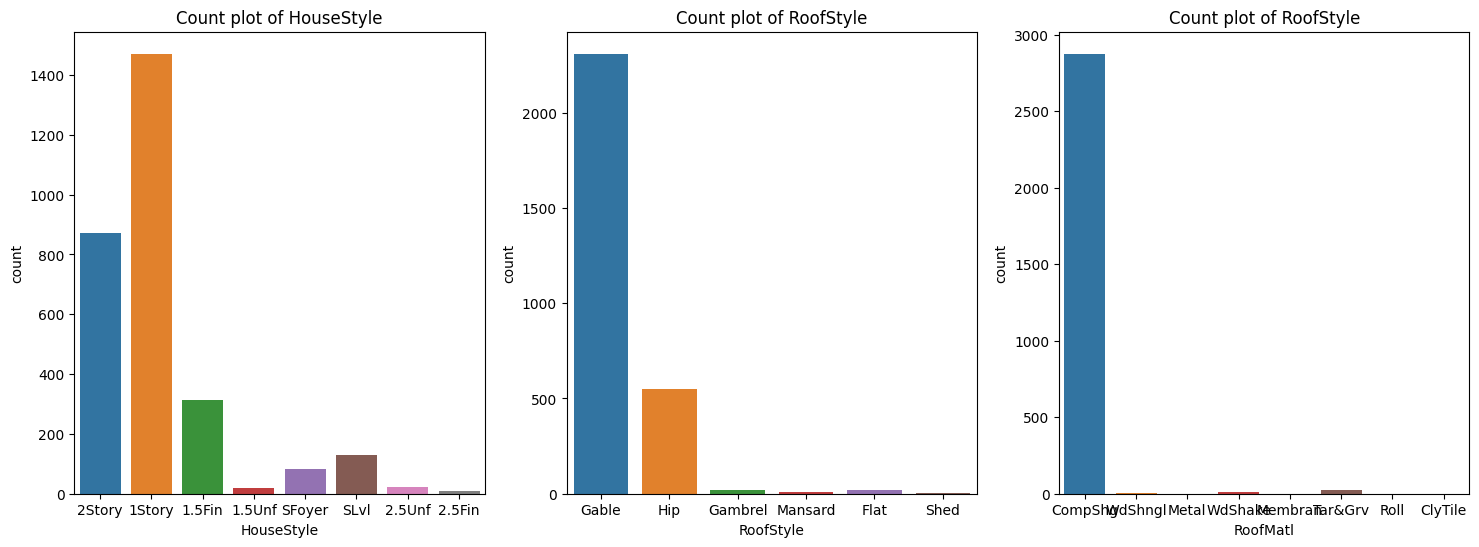

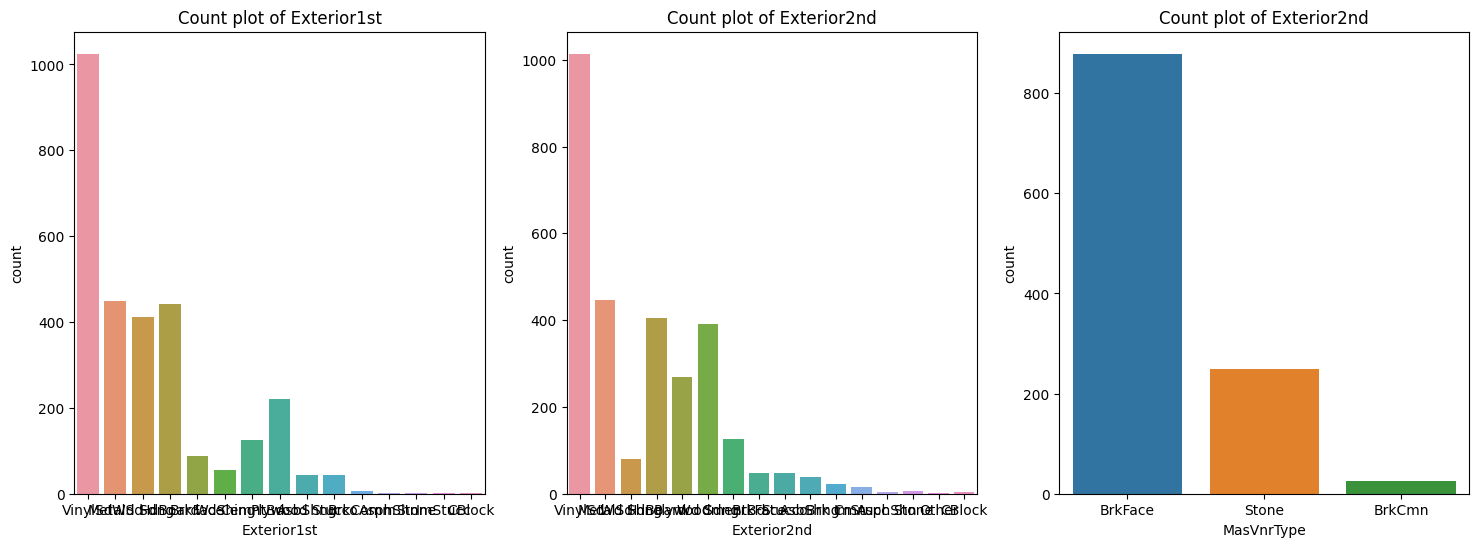

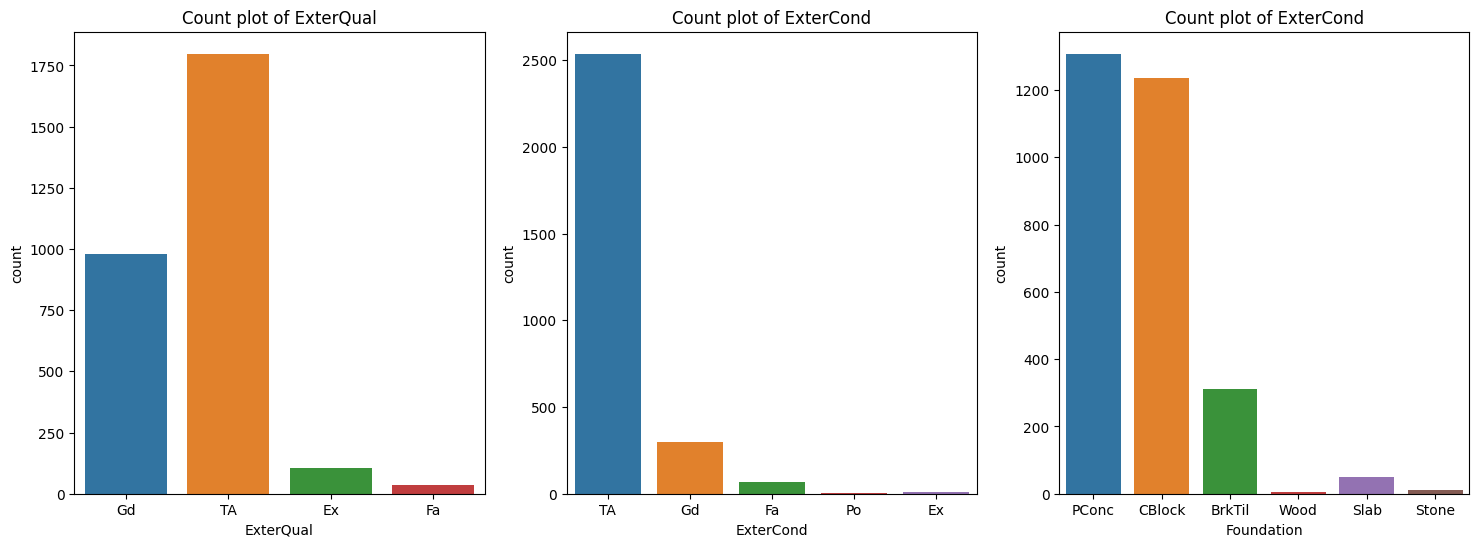

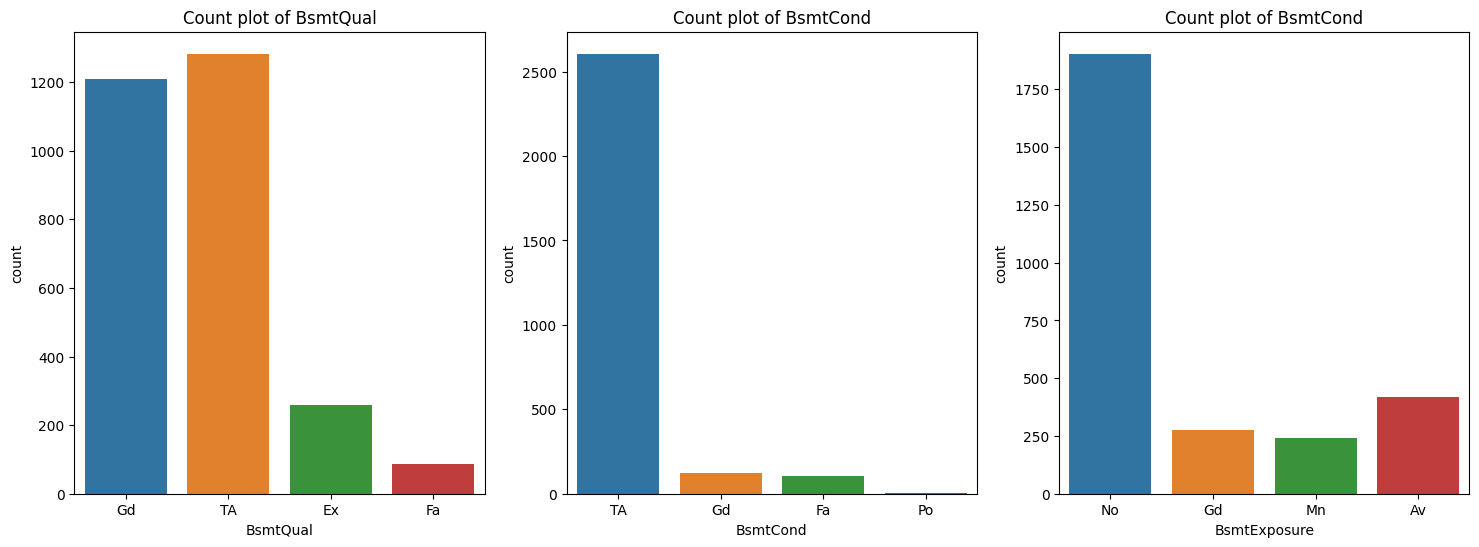

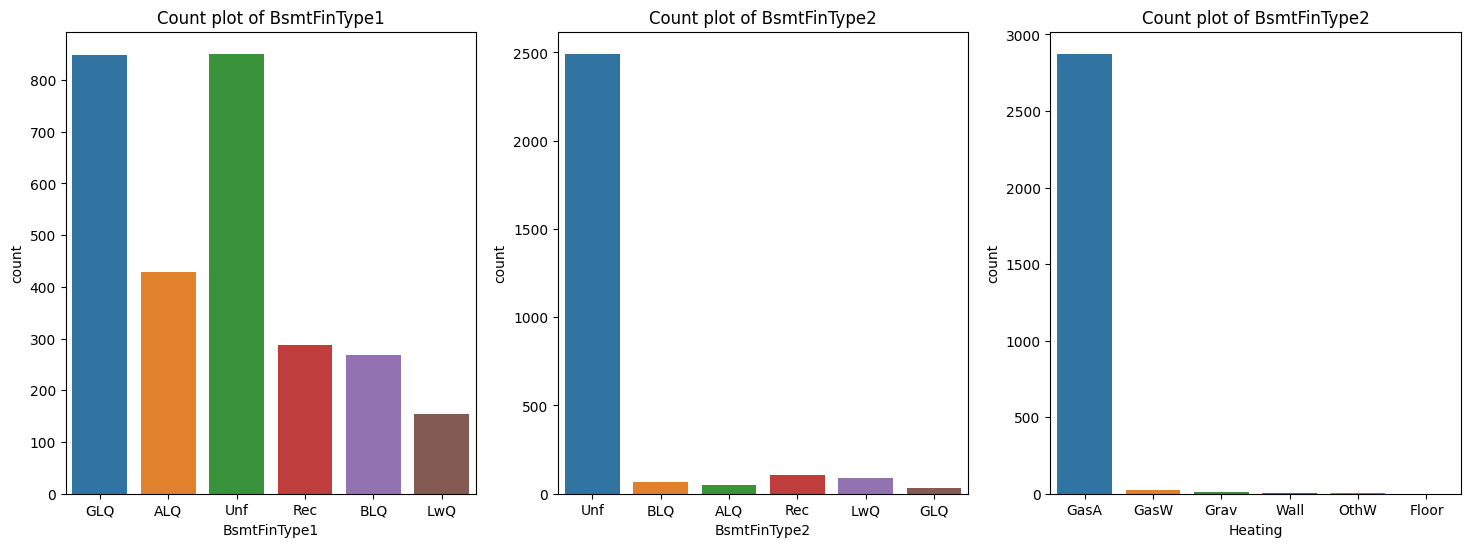

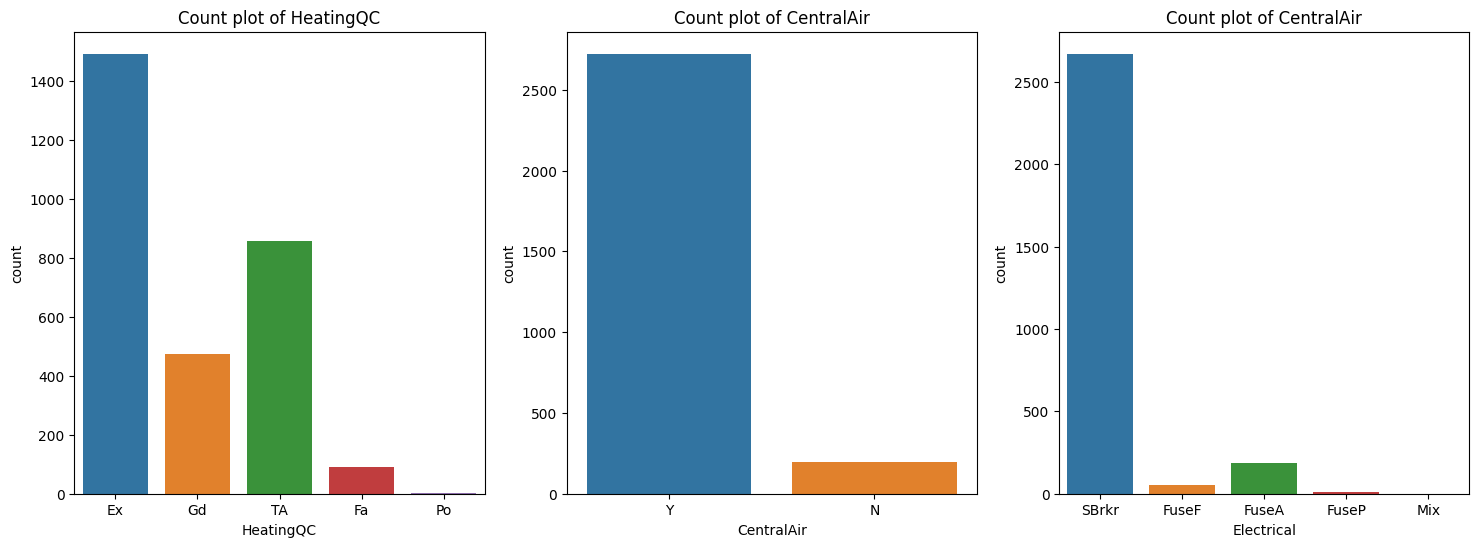

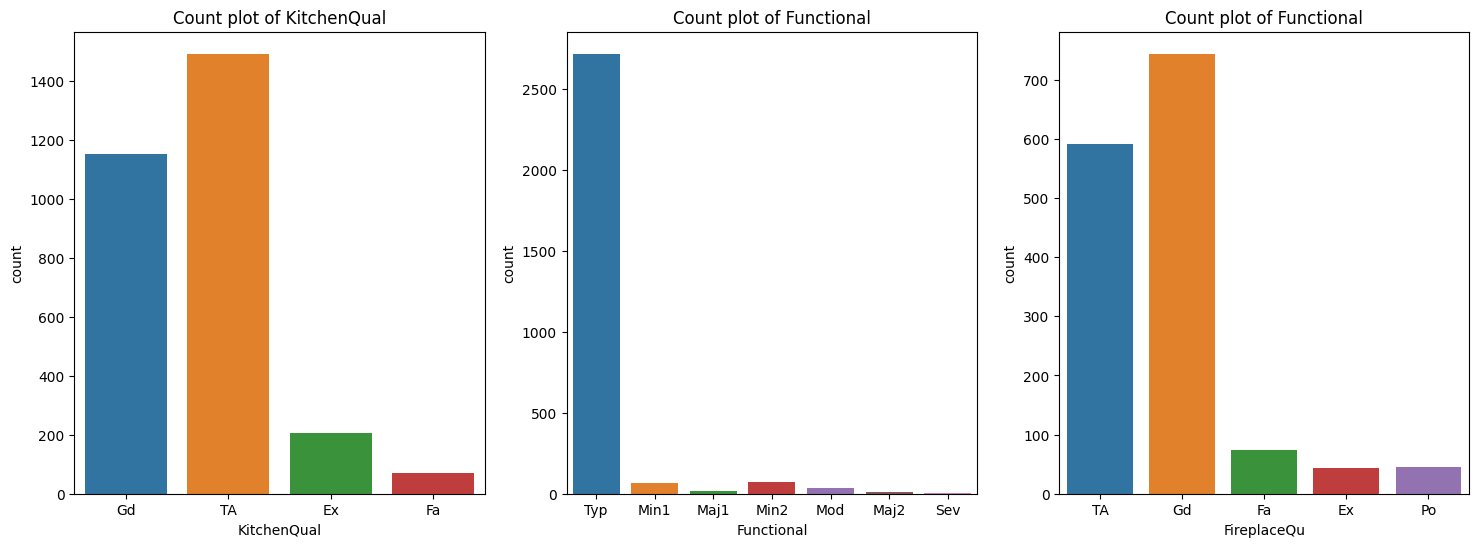

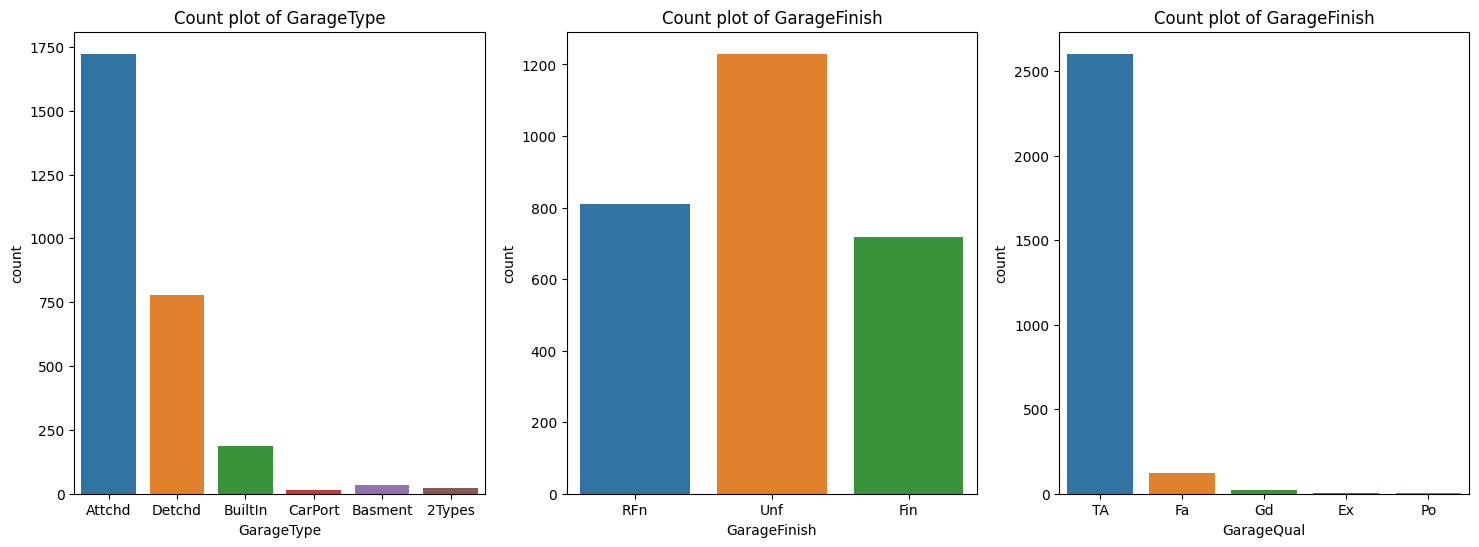

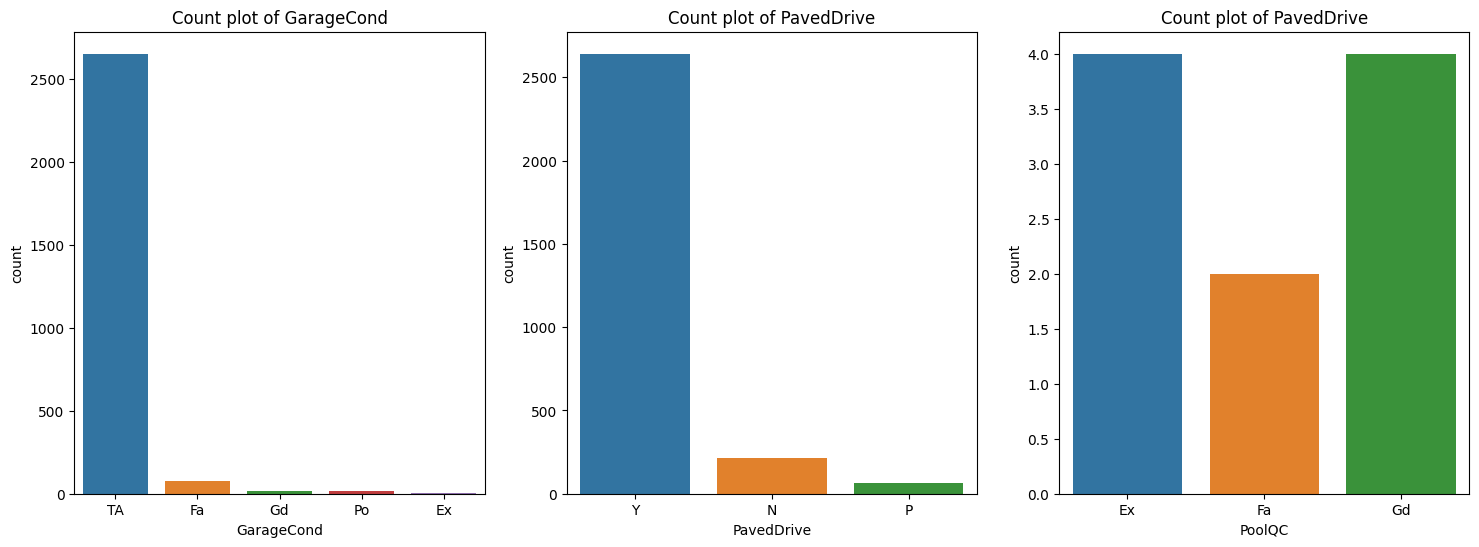

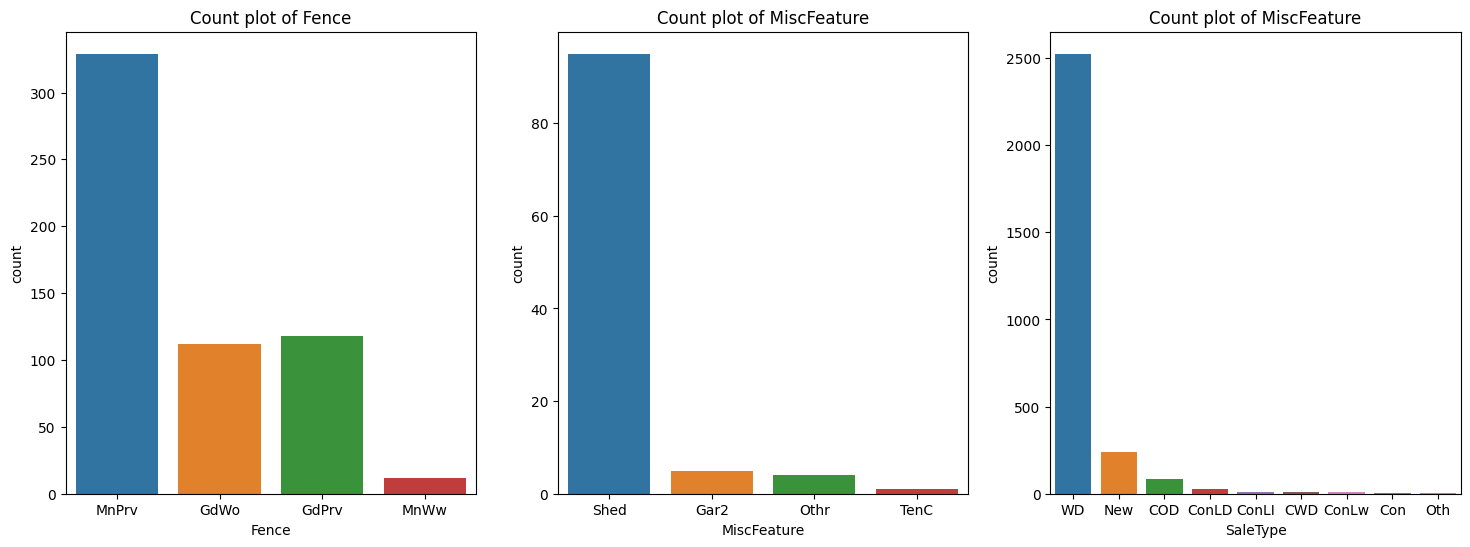

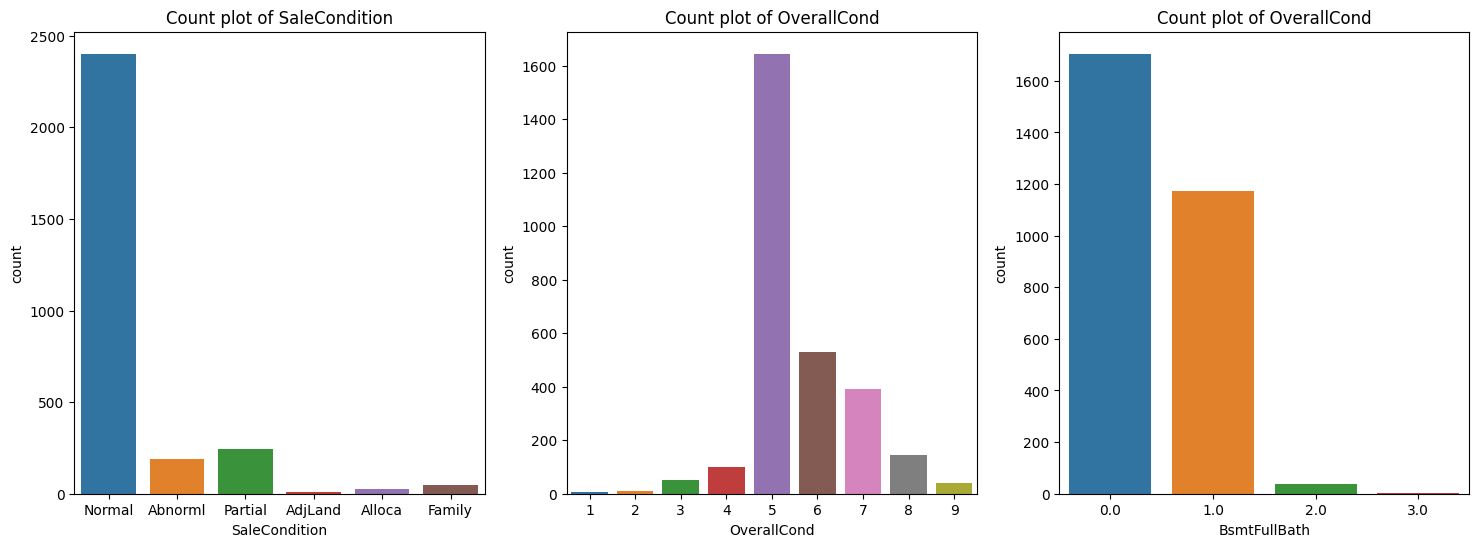

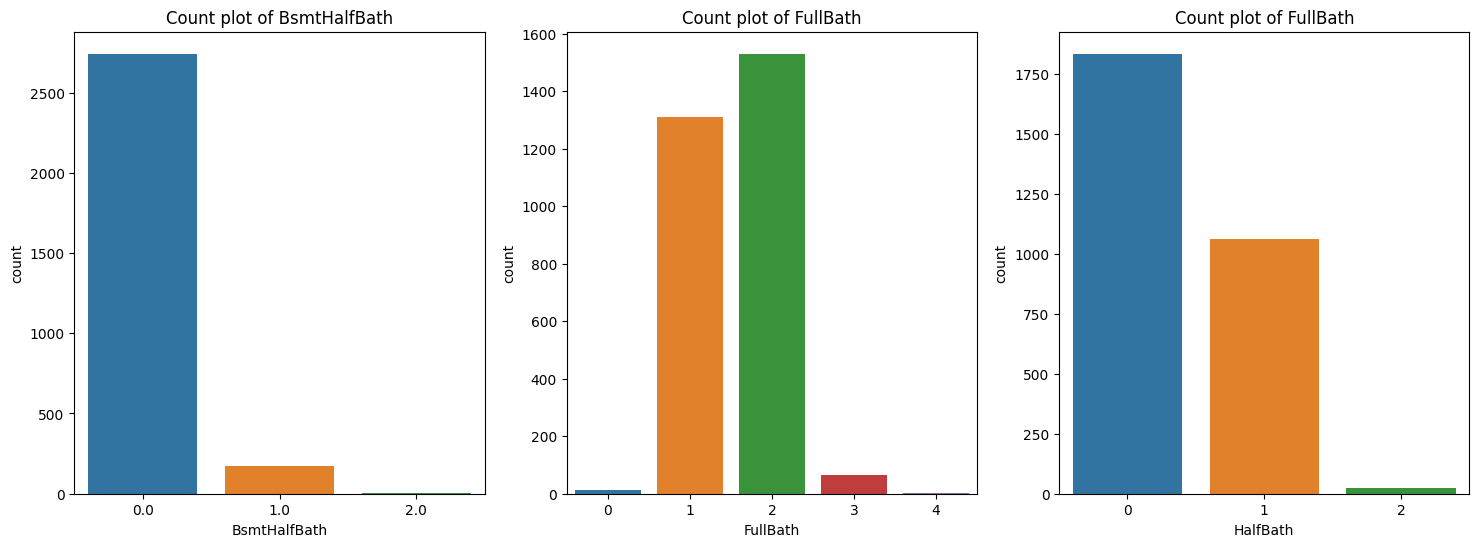

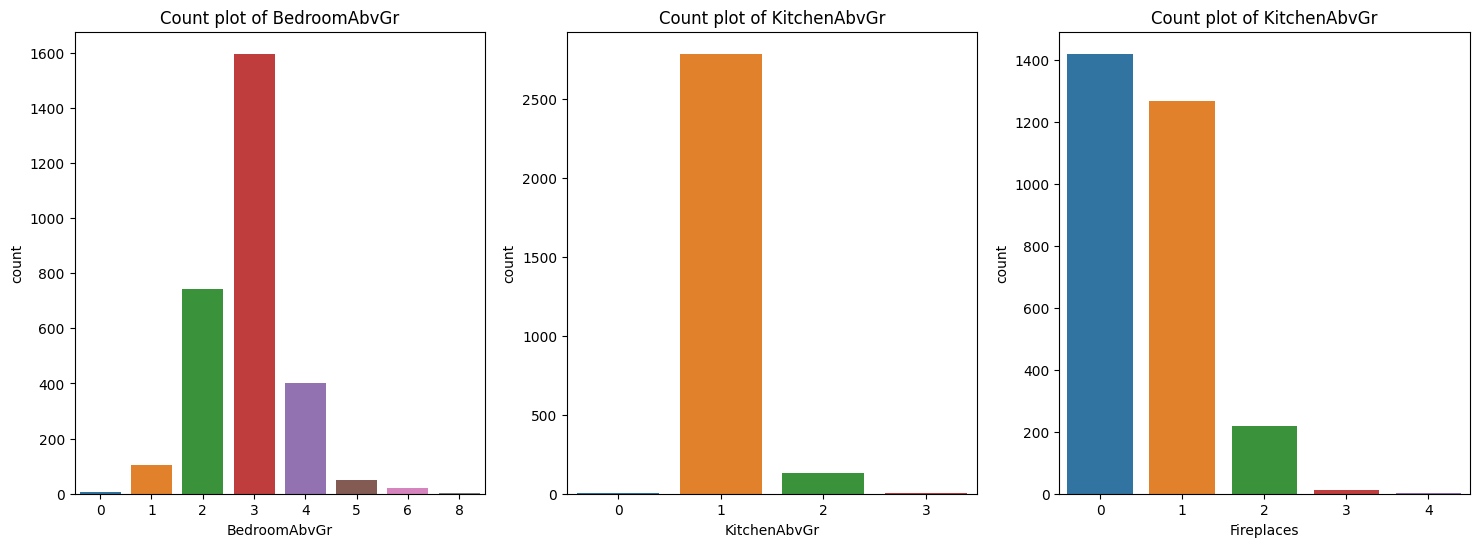

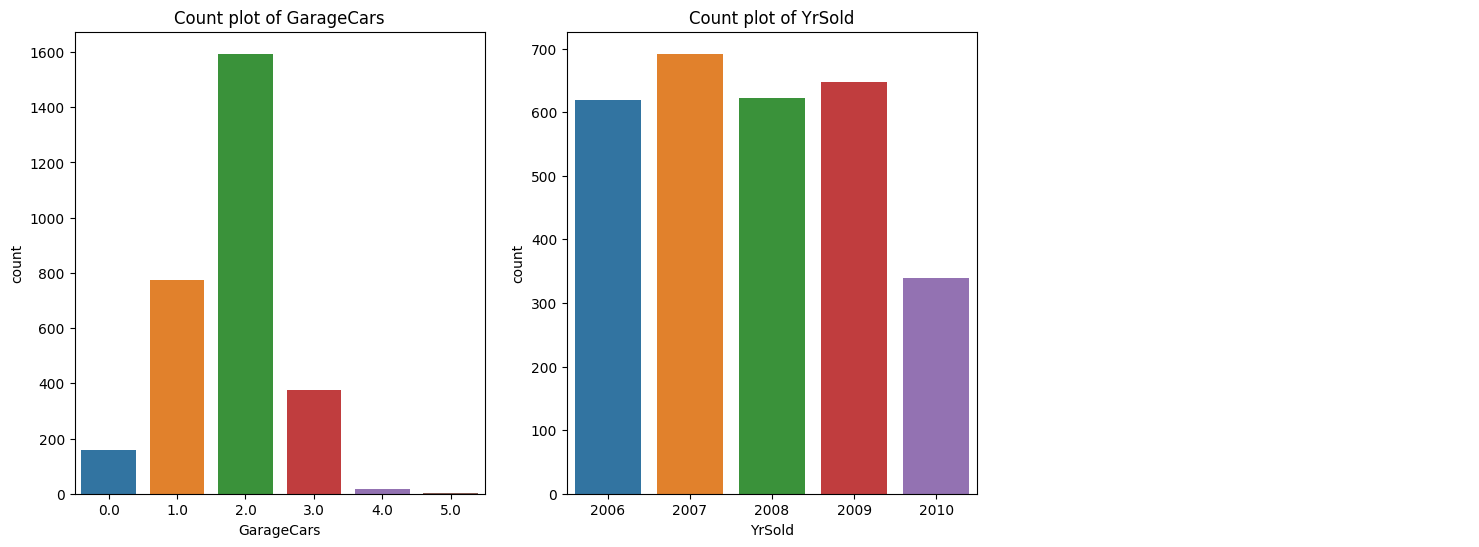

In [12]:
'''for i in cat_cols:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    sns.countplot(x = i, data = train ax = ax1)
    plt.show()'''

for idx in range(0, len(cat_cols), 3):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    sns.countplot(x=cat_cols[idx], data=train, ax=ax1)
    ax1.set_title(f'Count plot of {cat_cols[idx]}')
    
    if idx + 1 < len(cat_cols):  
        sns.countplot(x=cat_cols[idx + 1], data=train, ax=ax2)
        ax2.set_title(f'Count plot of {cat_cols[idx + 1]}')
    else:
        ax2.axis('off')  
        
    if idx + 2 < len(cat_cols):  
        sns.countplot(x=cat_cols[idx + 2], data=train, ax=ax3)
        ax3.set_title(f'Count plot of {cat_cols[idx + 1]}')
    else:
        ax3.axis('off')  

    plt.show()

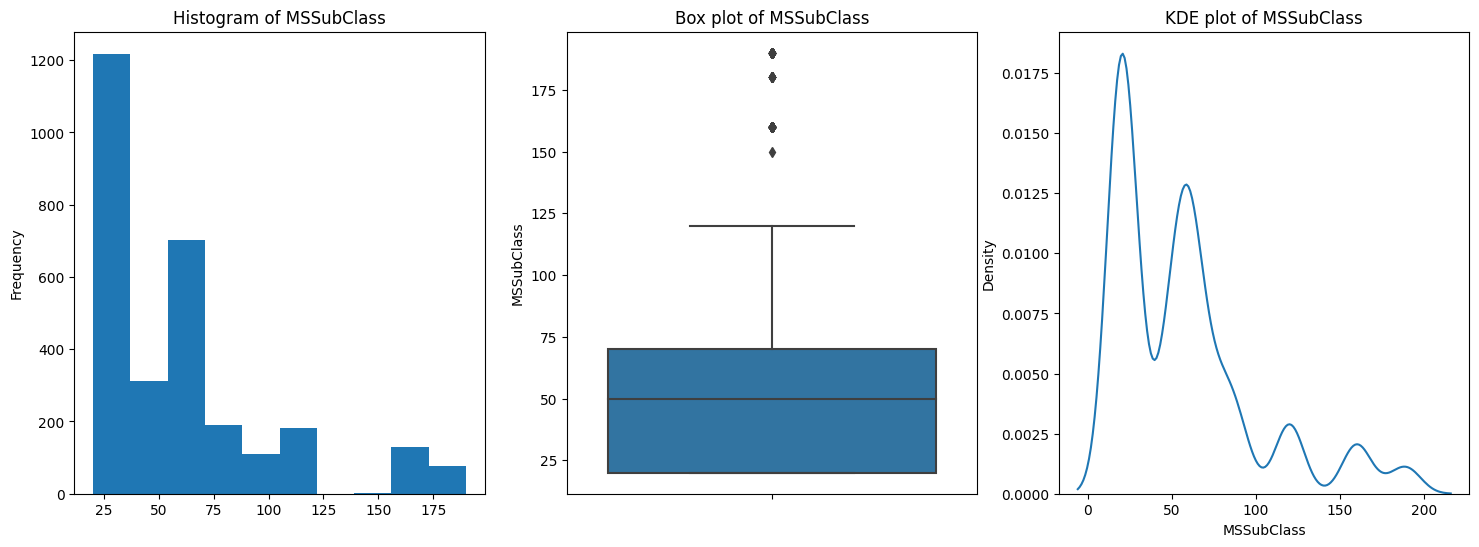

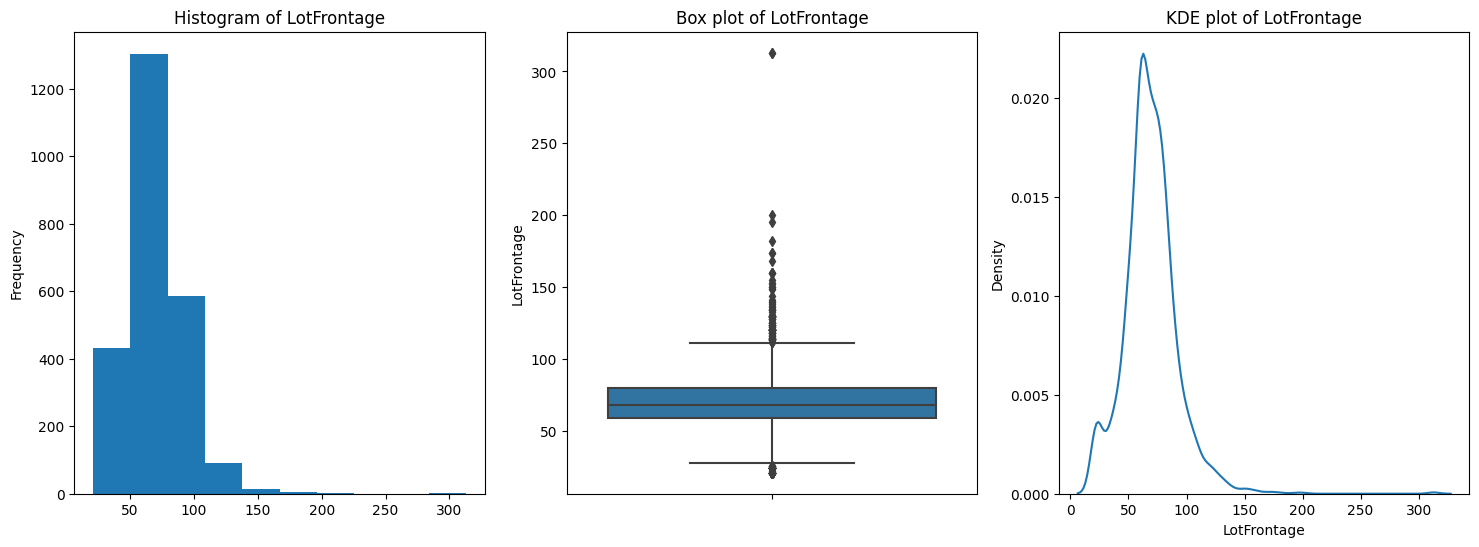

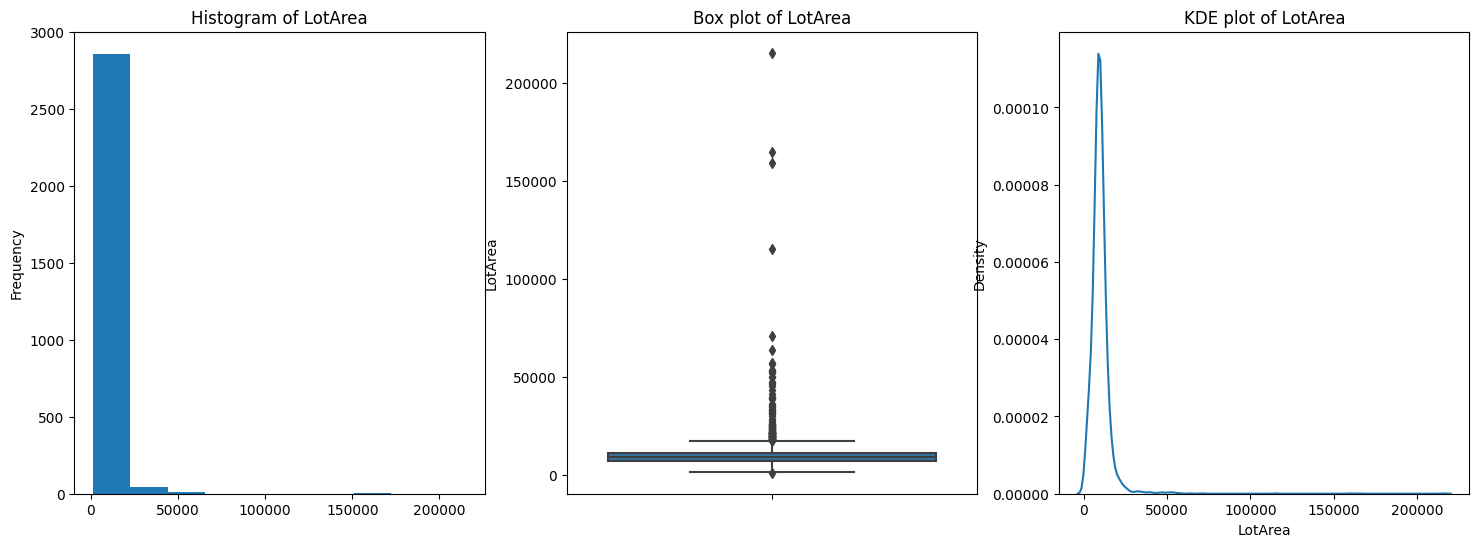

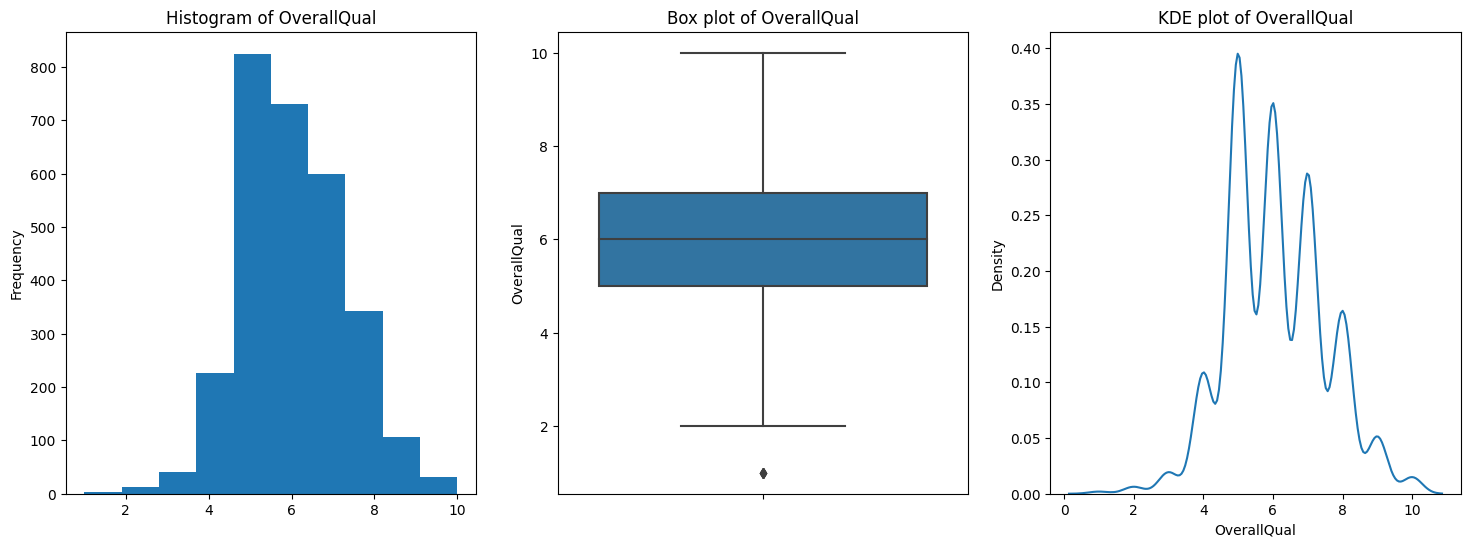

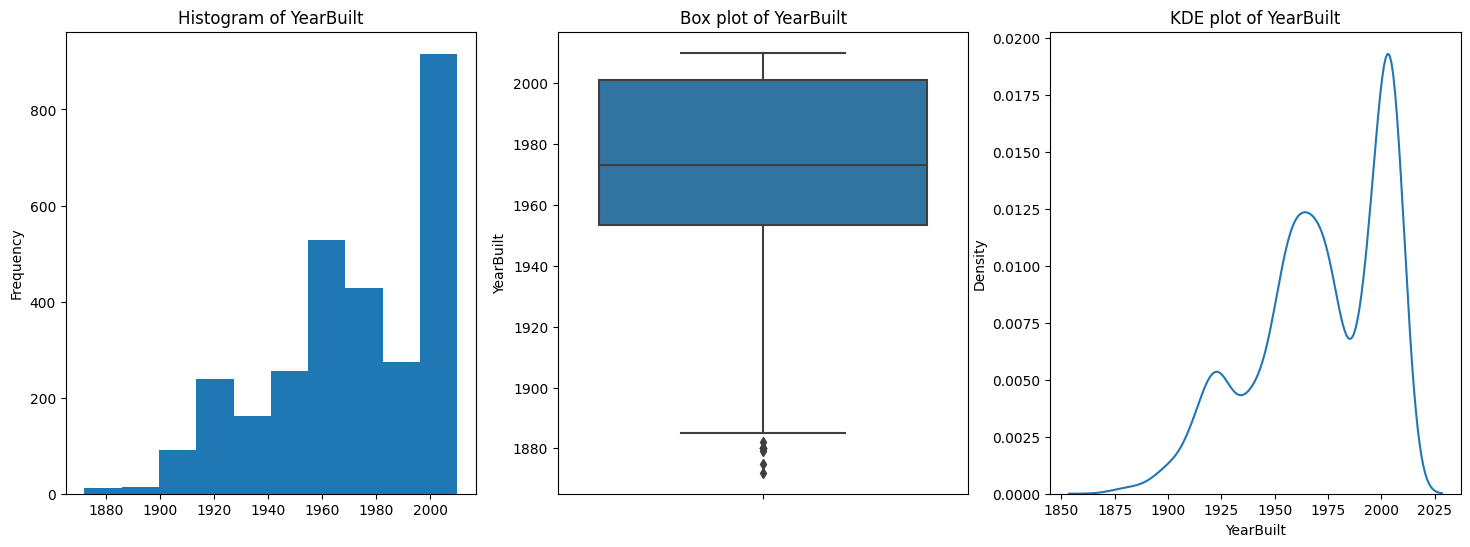

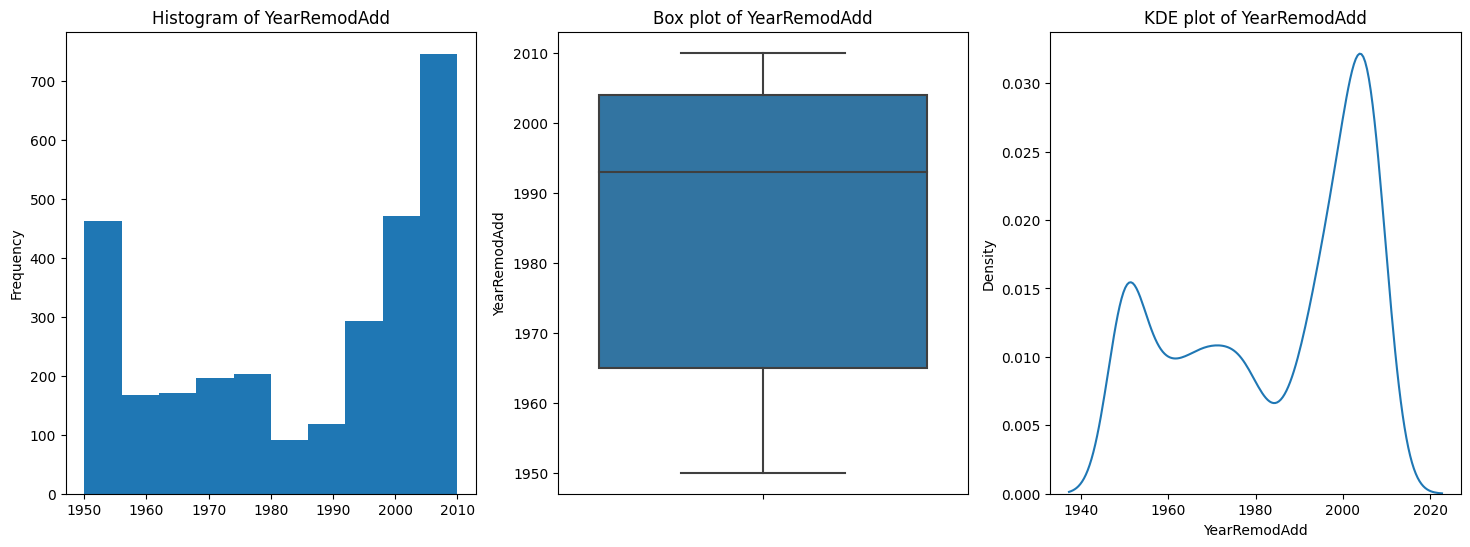

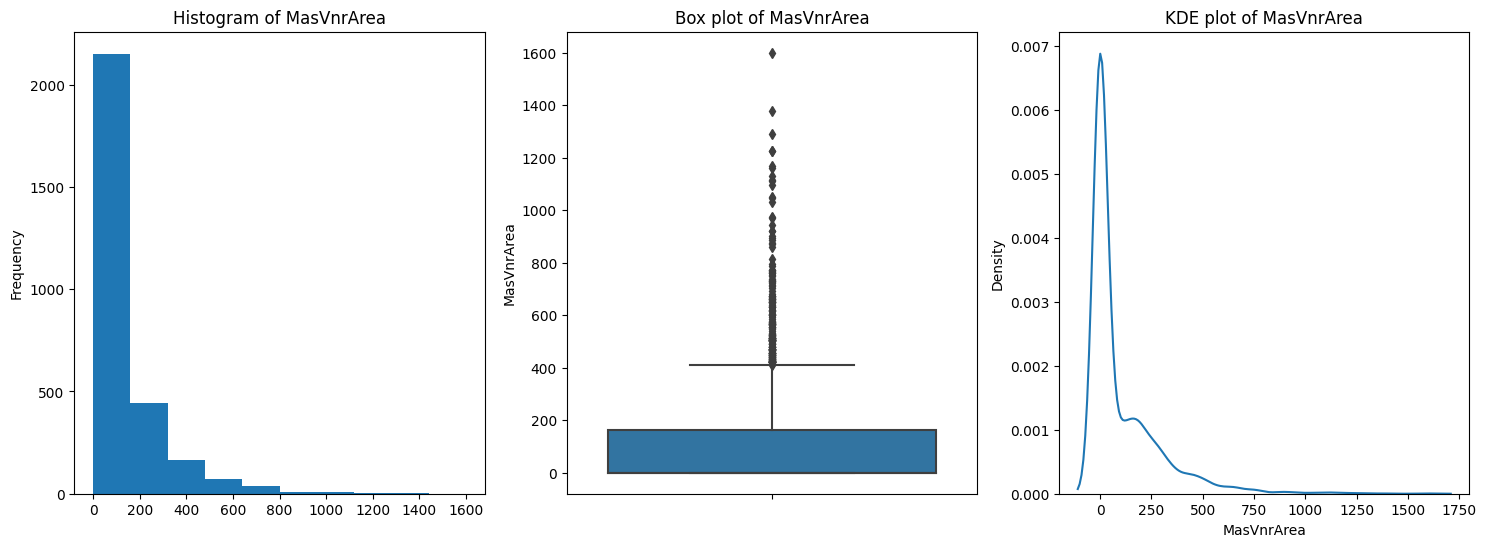

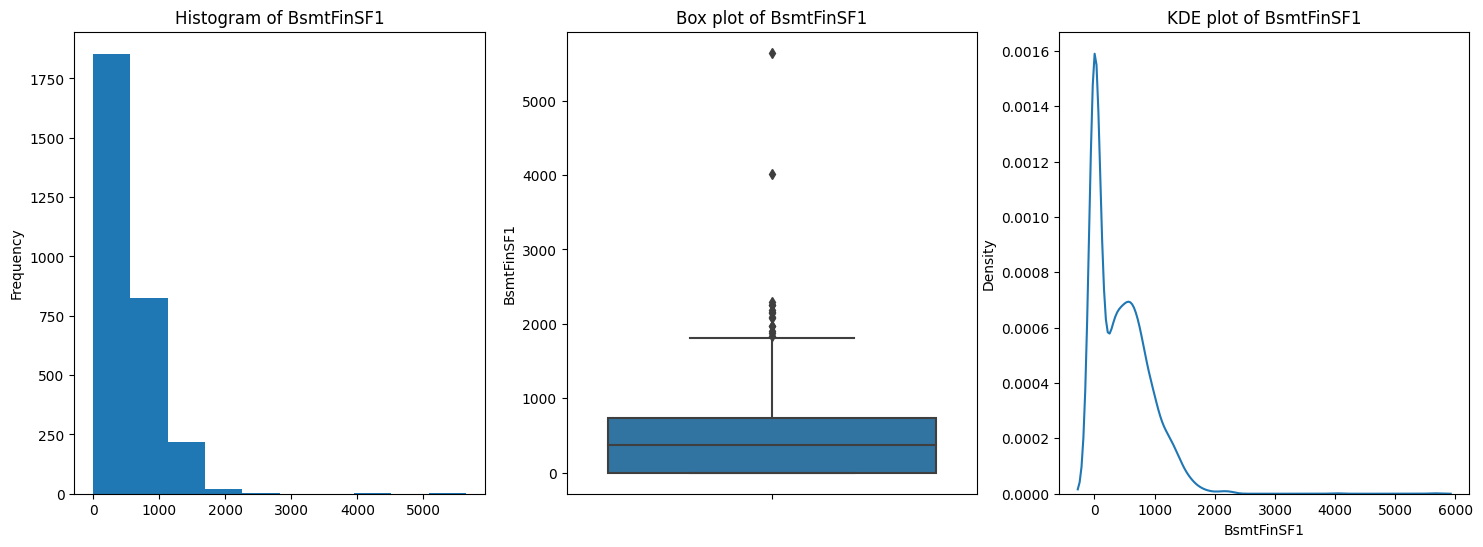

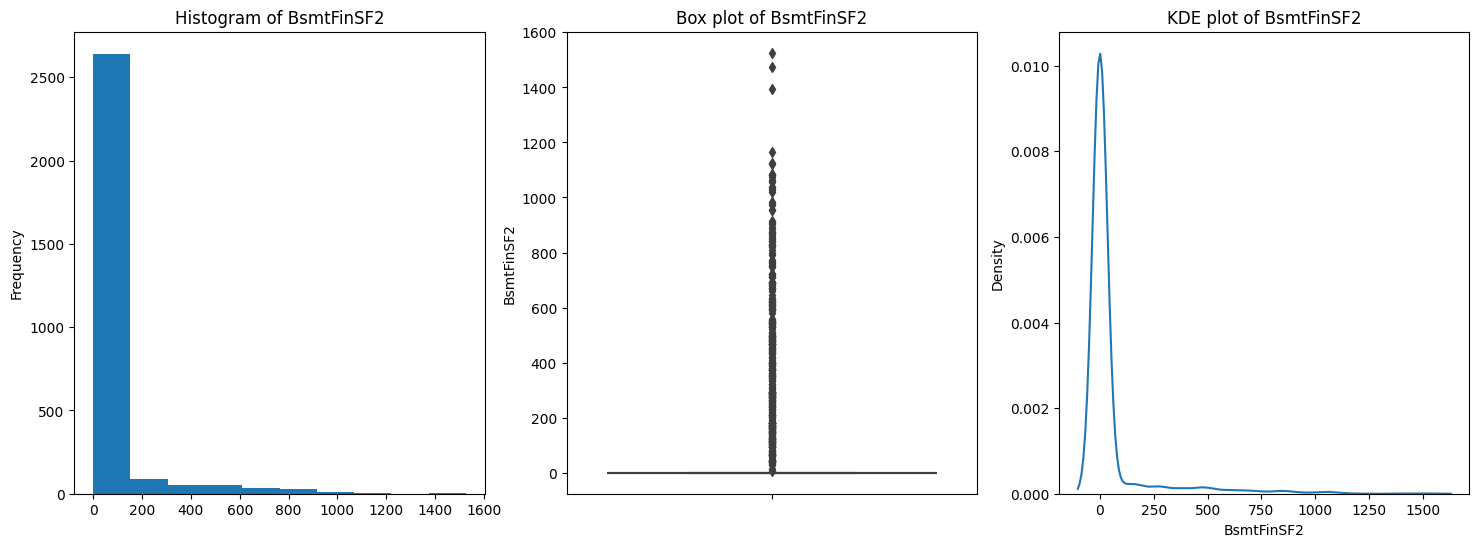

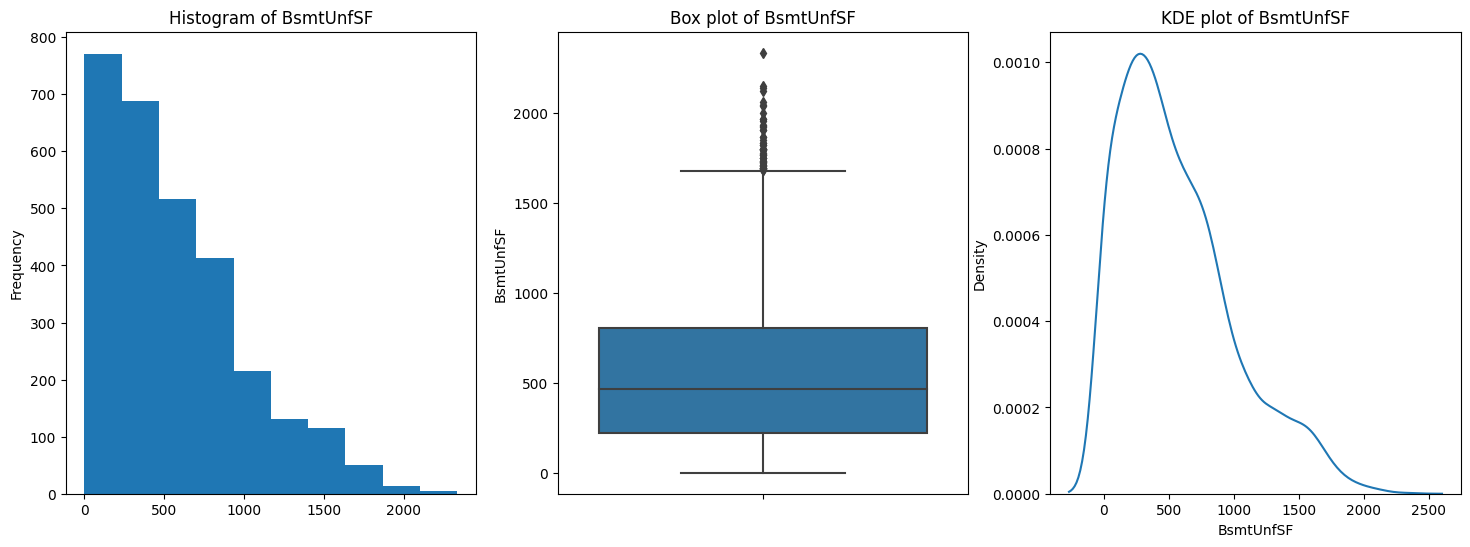

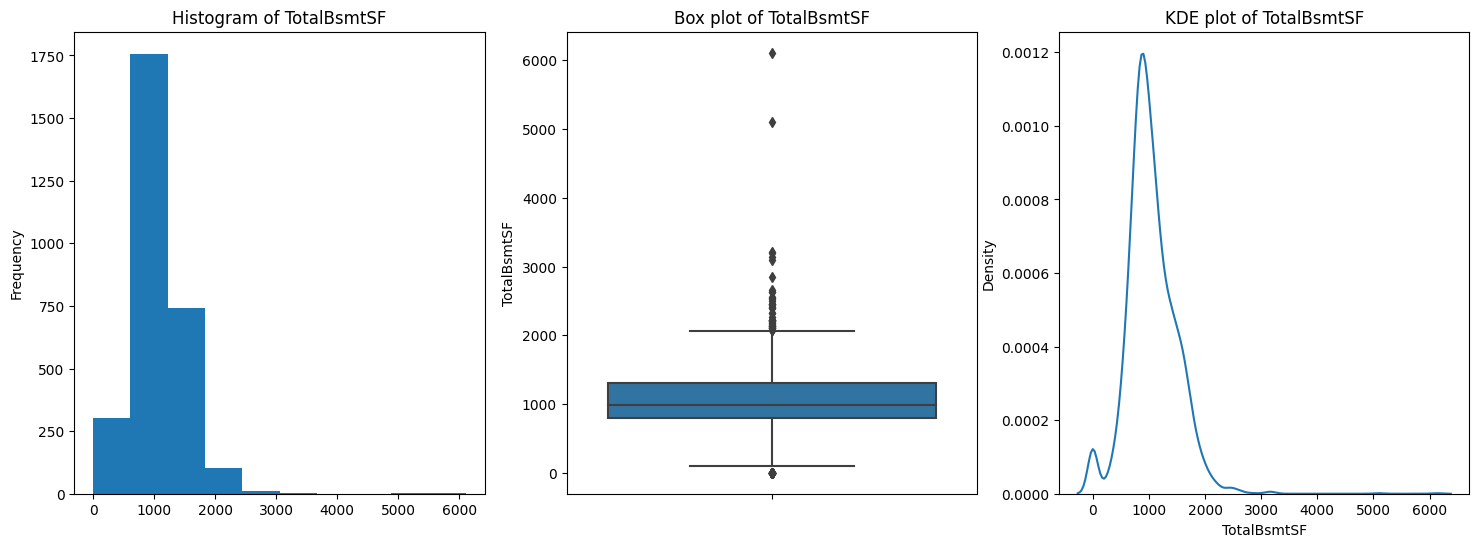

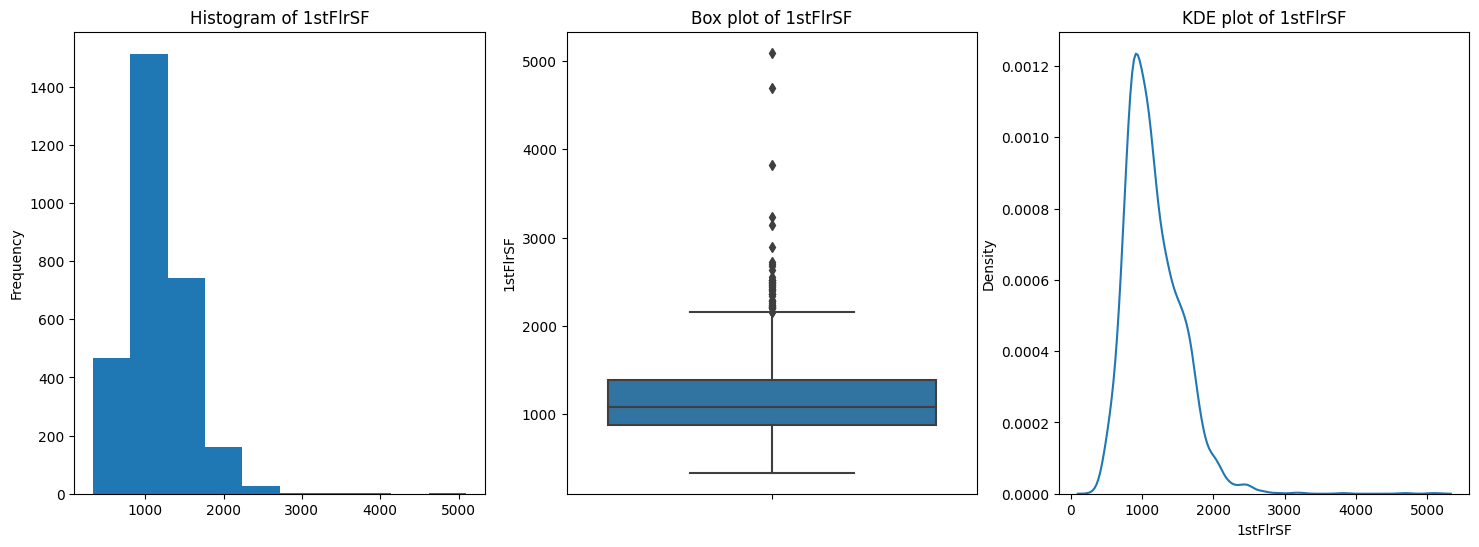

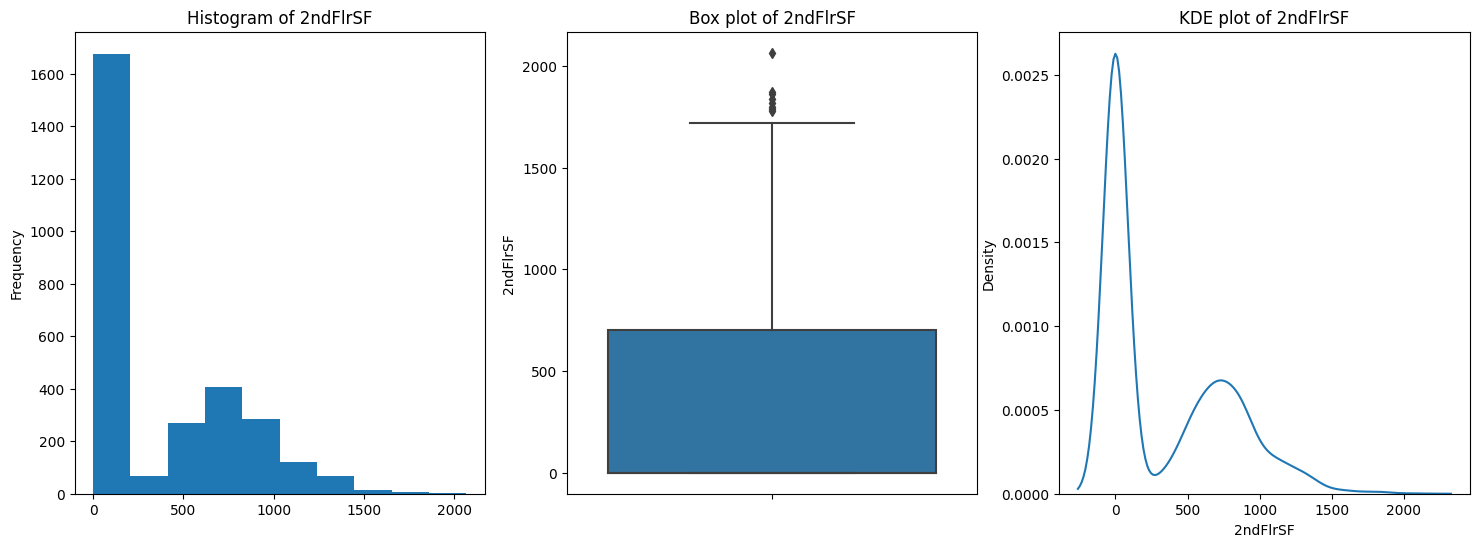

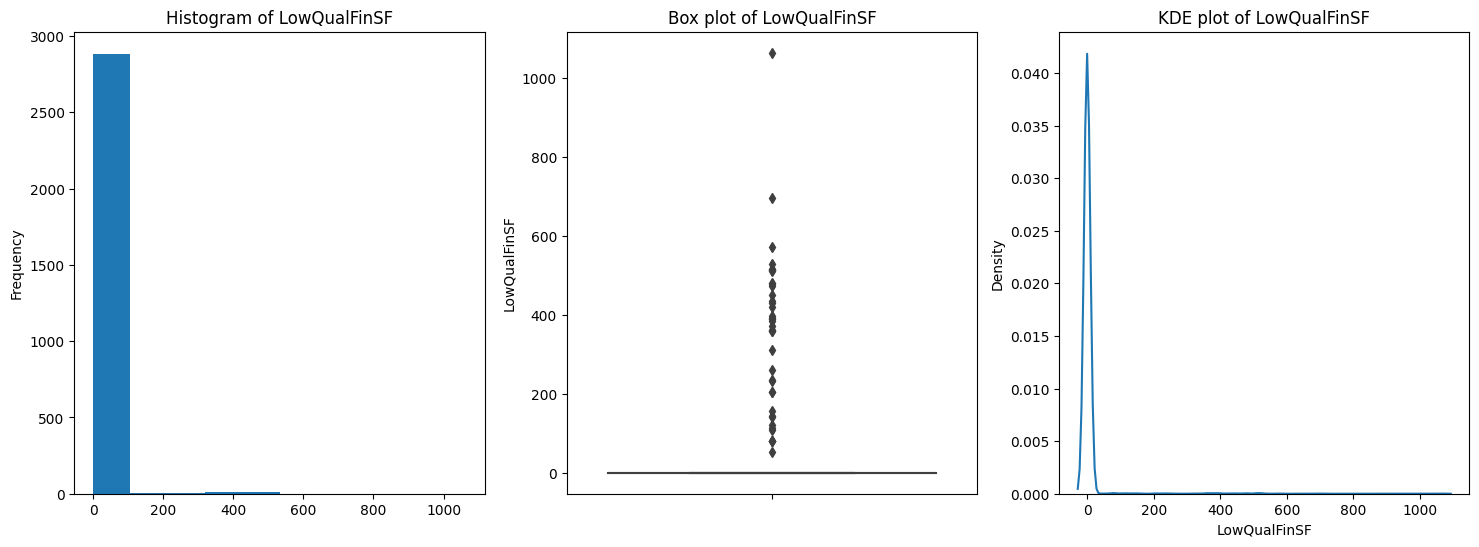

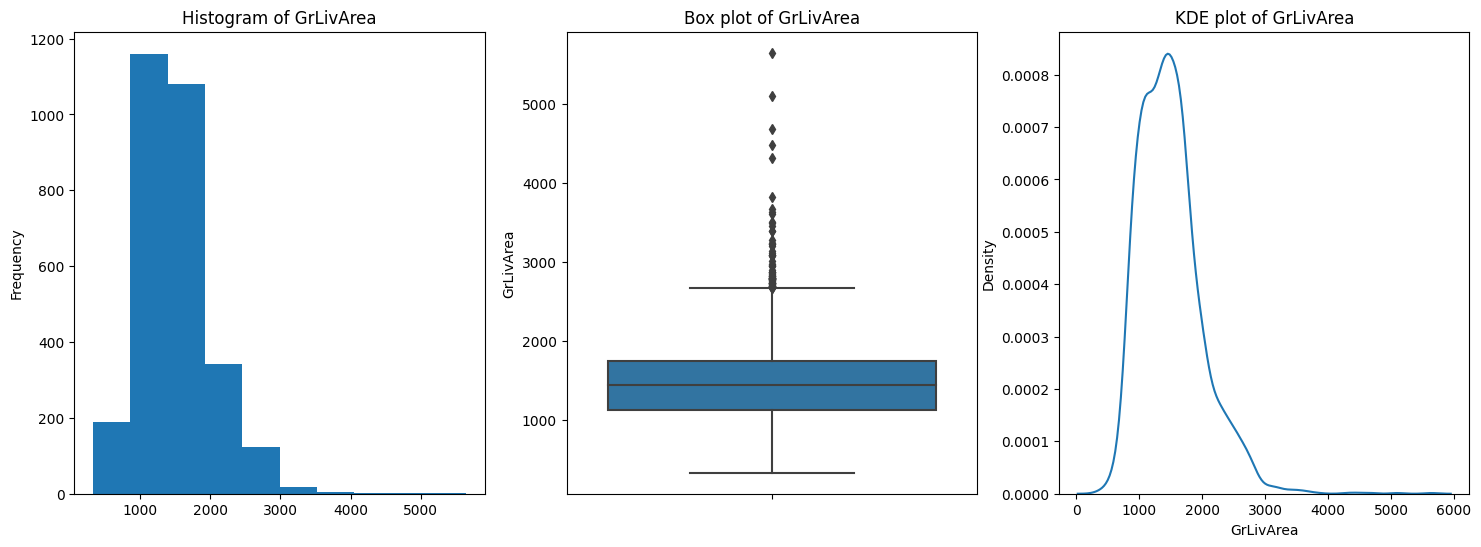

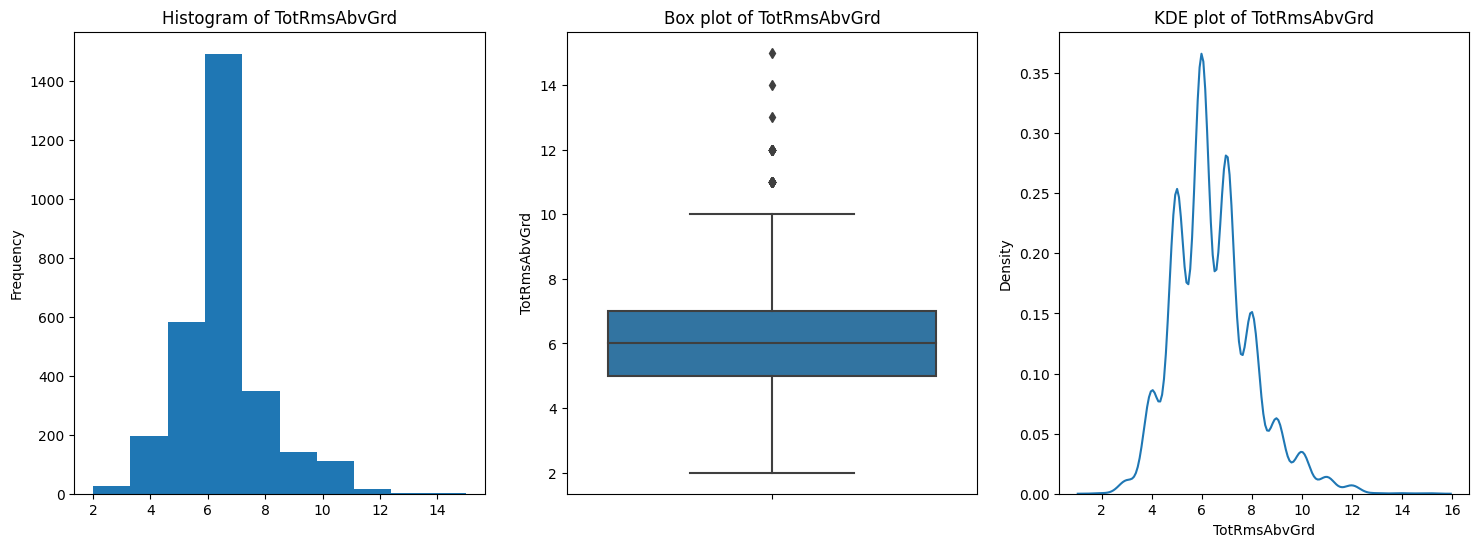

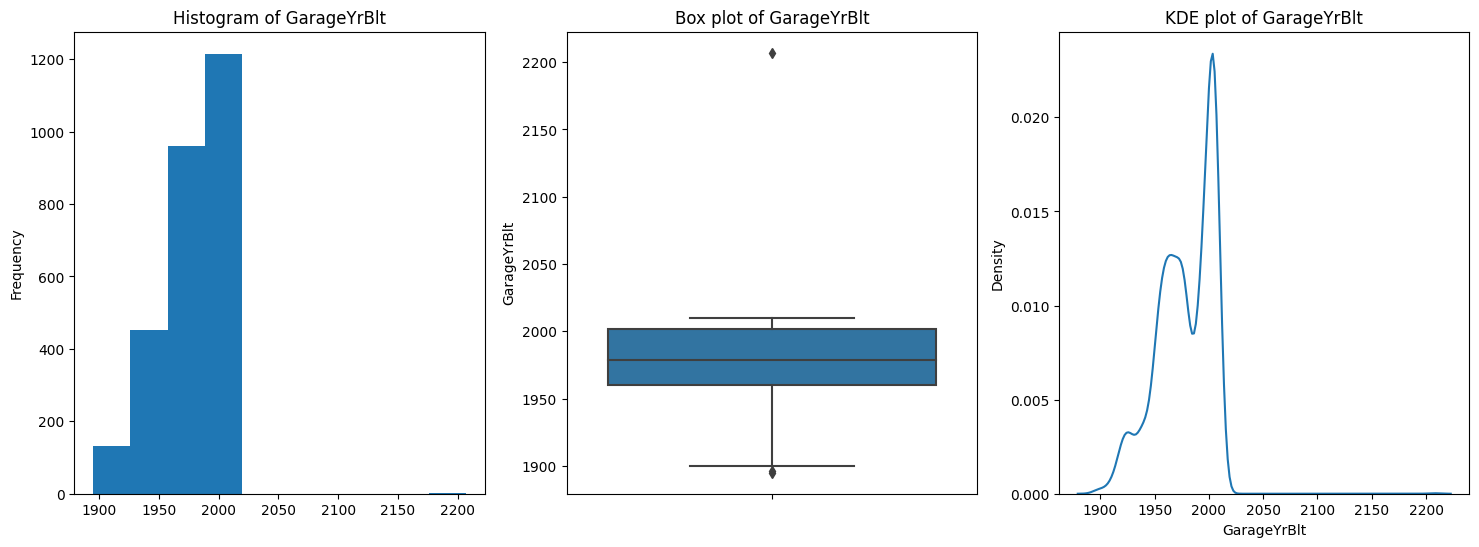

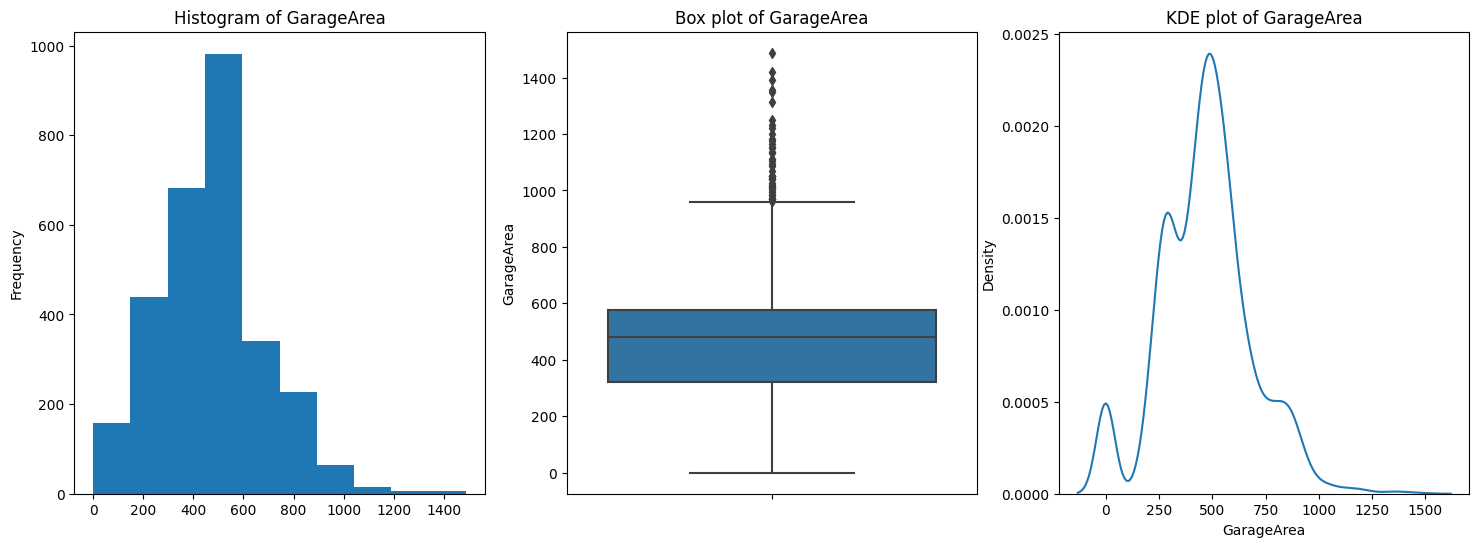

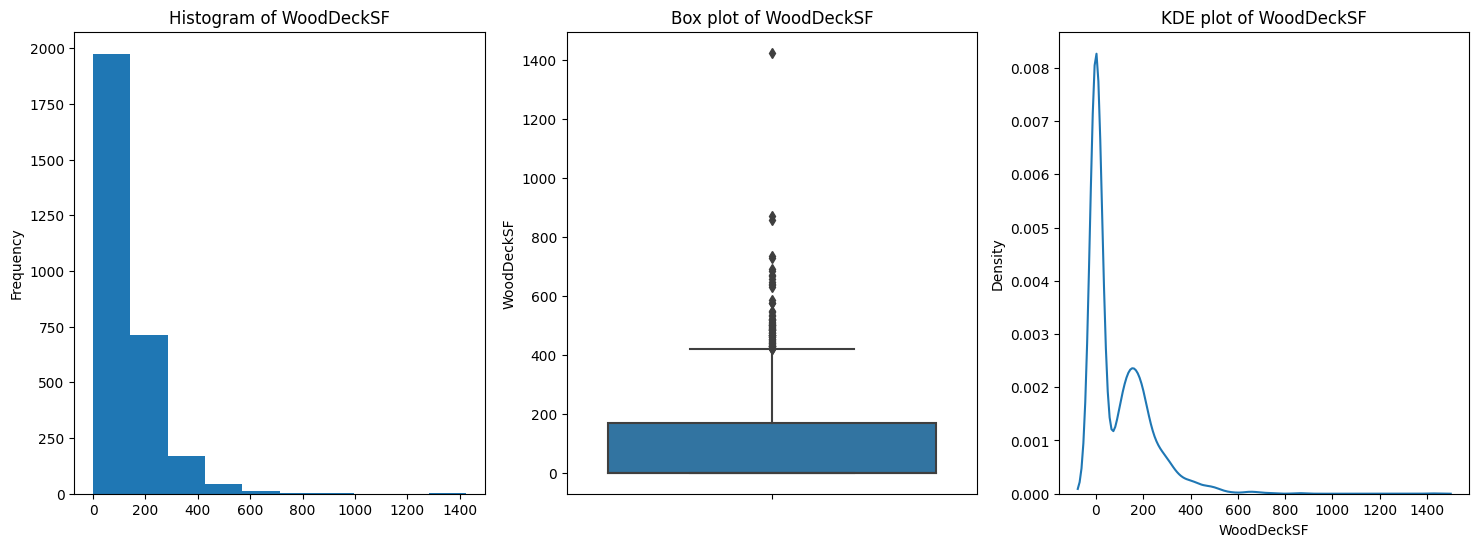

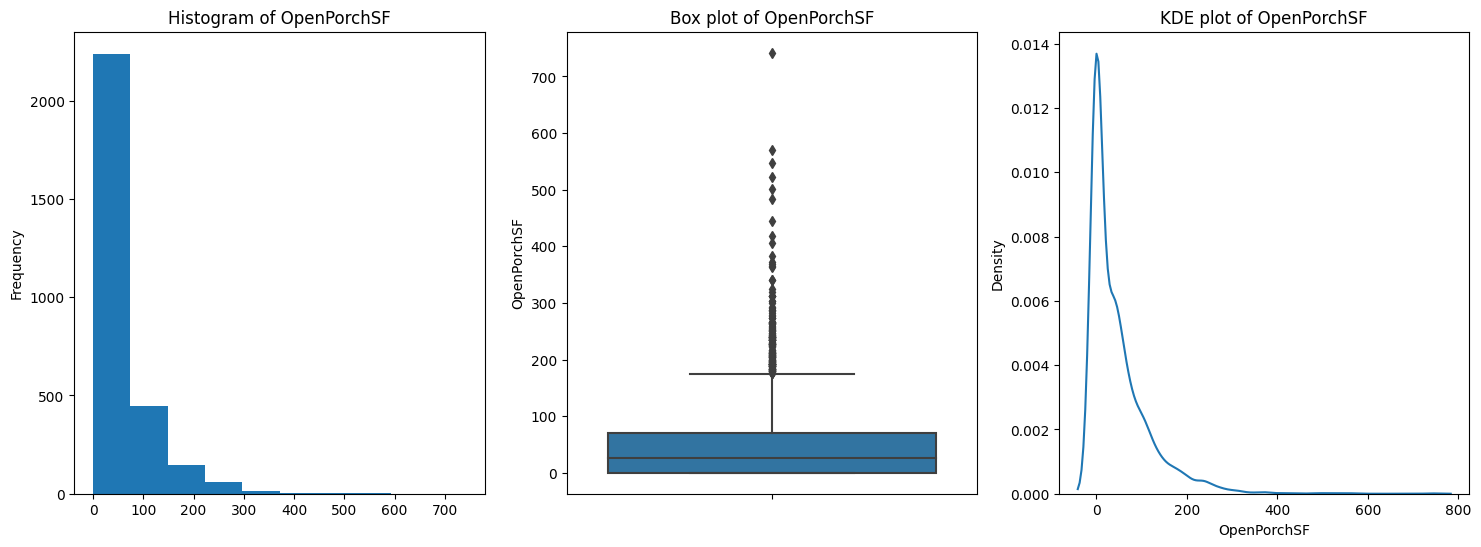

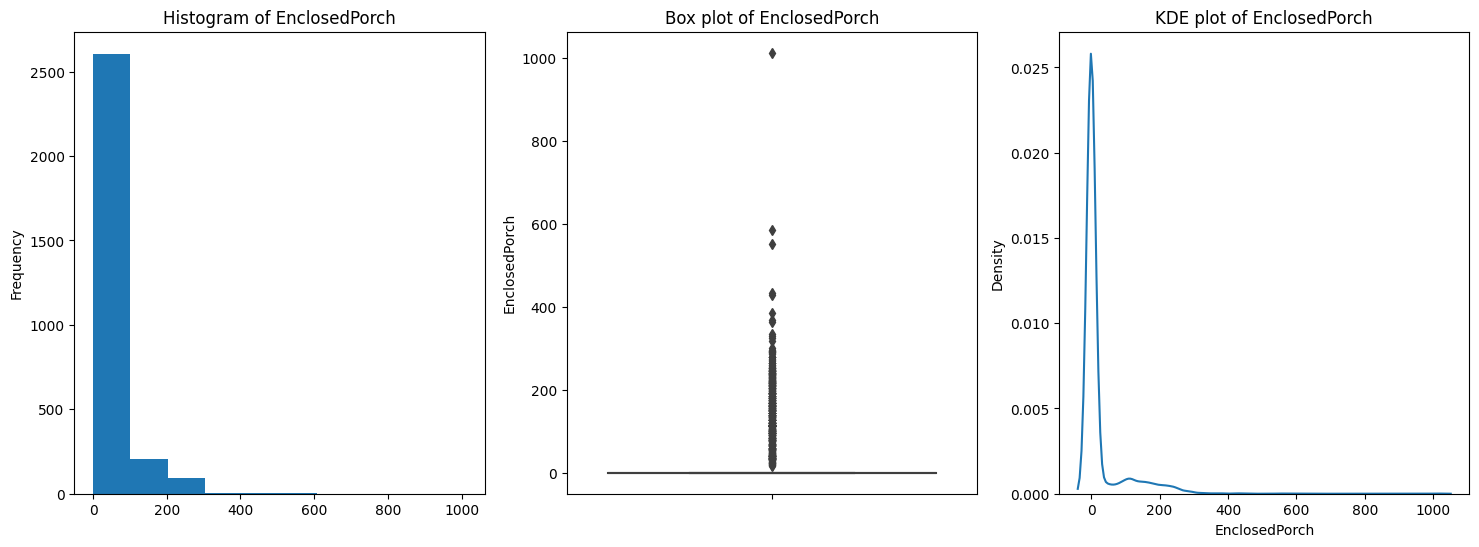

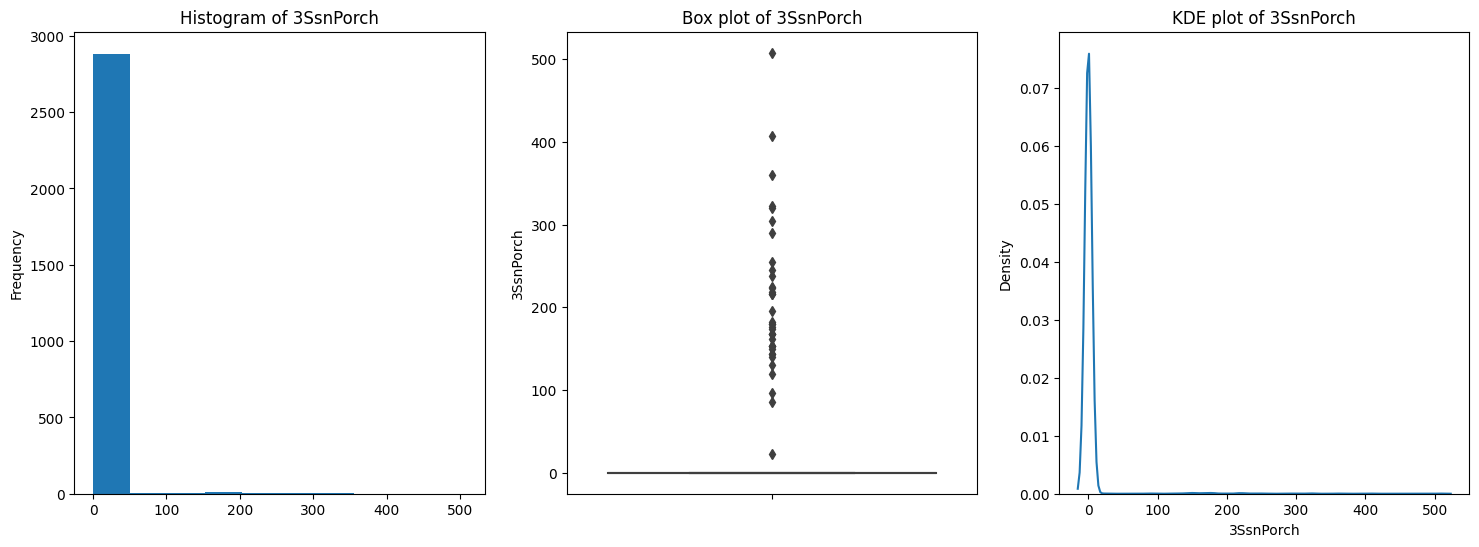

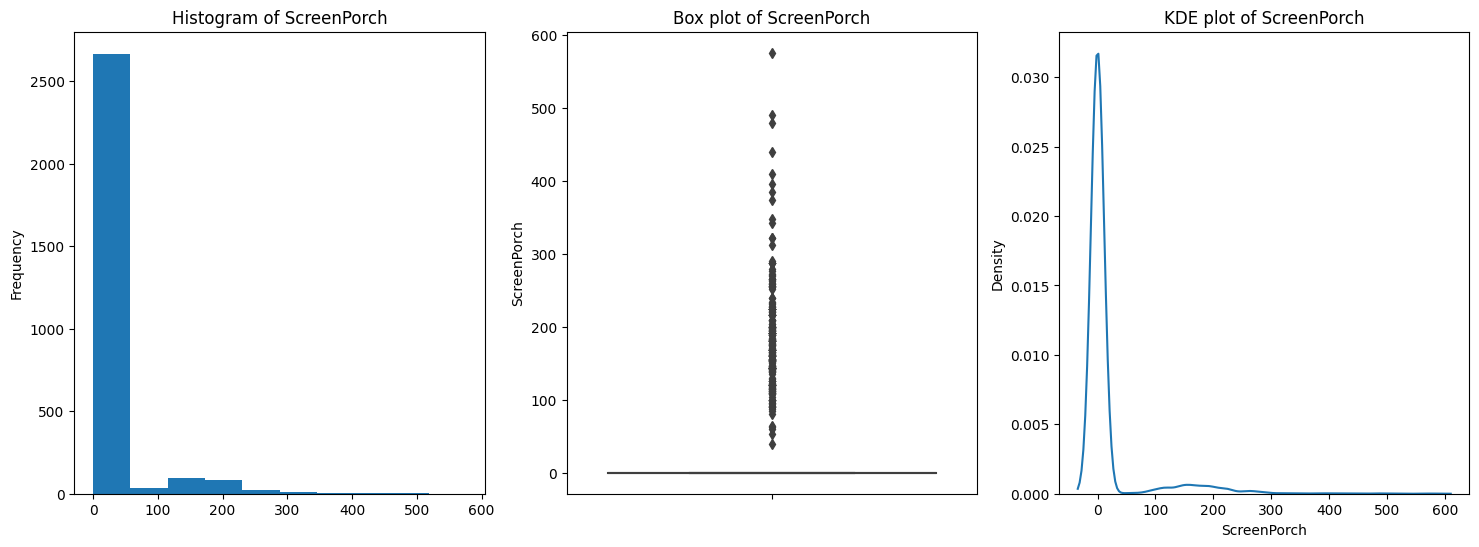

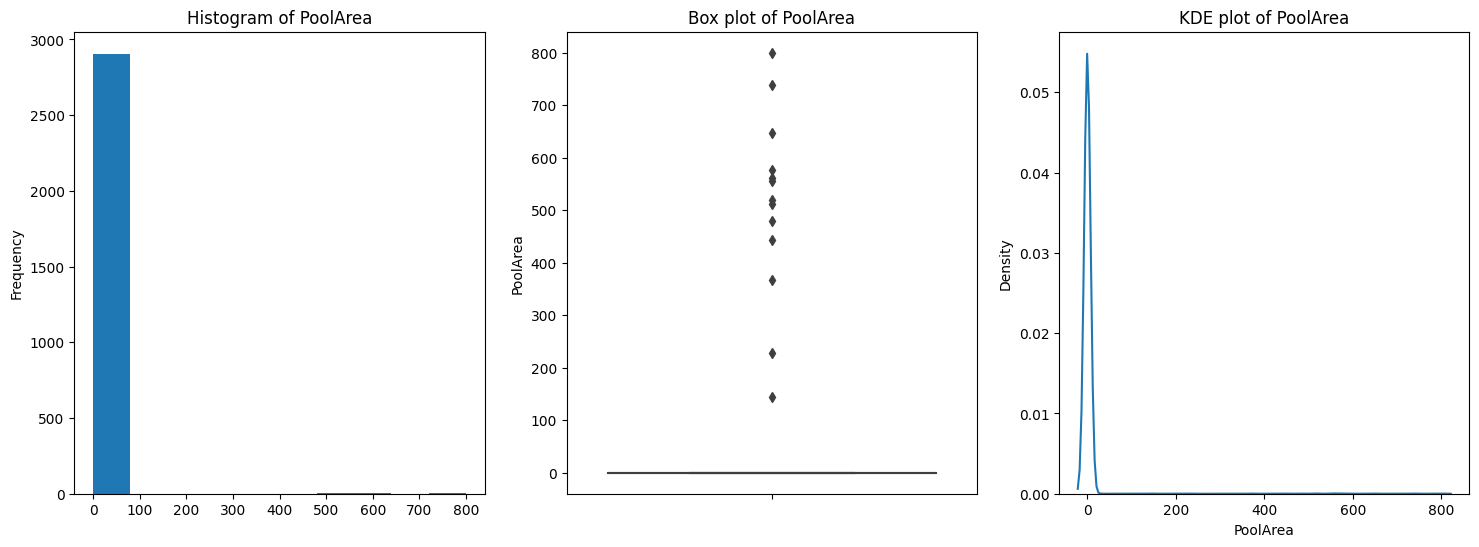

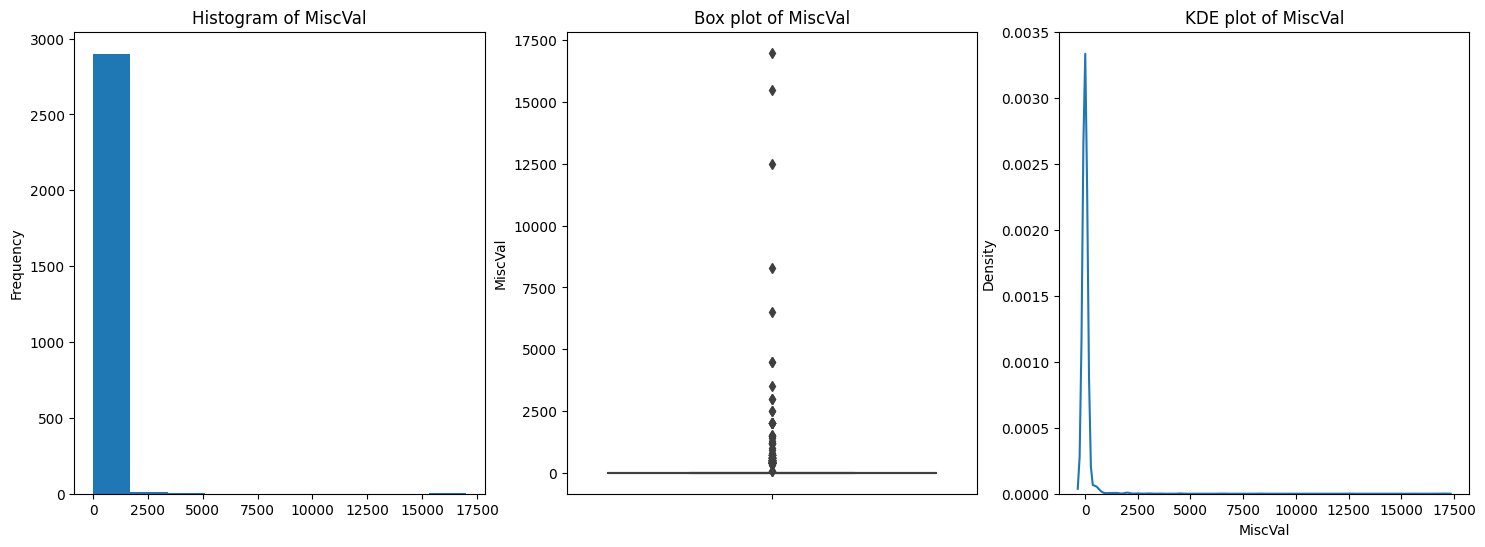

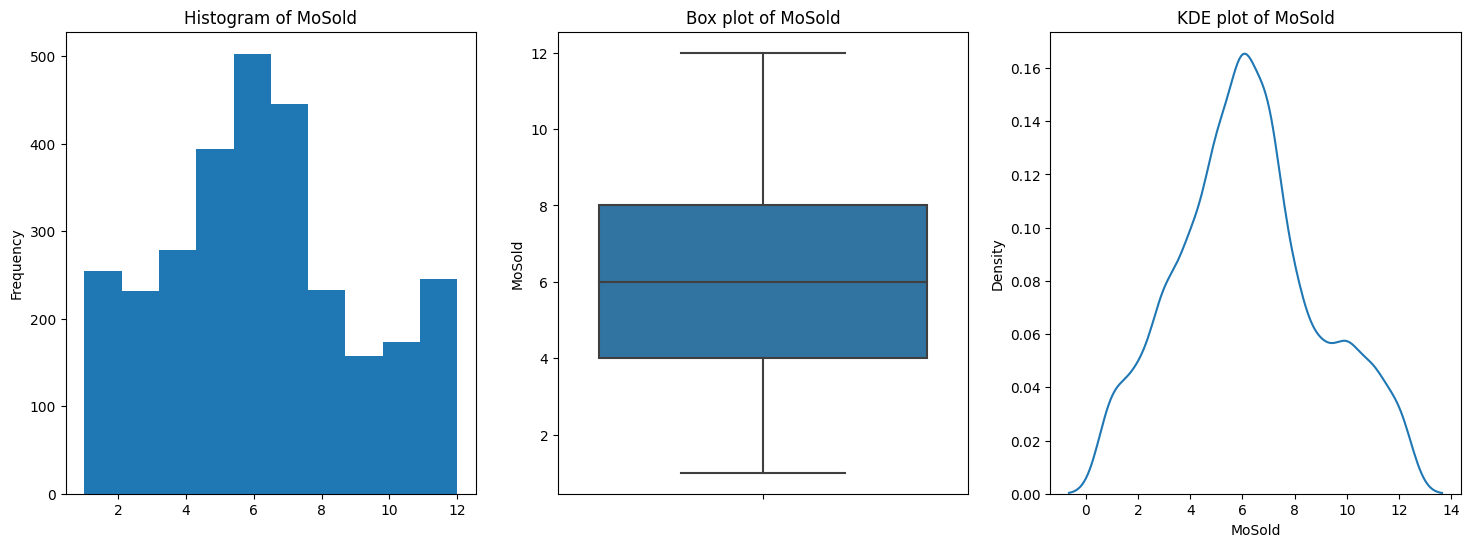

In [13]:
for i in num_cols:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    train[i].plot(kind = 'hist', ax = ax1)
    ax1.set_title(f'Histogram of {i}')
    sns.boxplot(y = train[i], data = train, ax = ax2)
    ax2.set_title(f'Box plot of {i}')
    sns.kdeplot(train[i], ax = ax3)
    ax3.set_title(f'KDE plot of {i}')
    plt.show()

# **Handling Missing Values**

**For categorical Columns**

In [14]:
miss_cat = []
for i in cat_cols:
    if train[i].isnull().sum() > 0:
        miss_cat.append(i)
        print("Number of missing values in",i,"=", train[i].isnull().sum())

Number of missing values in MSZoning = 4
Number of missing values in Alley = 2721
Number of missing values in Utilities = 2
Number of missing values in Exterior1st = 1
Number of missing values in Exterior2nd = 1
Number of missing values in MasVnrType = 1766
Number of missing values in BsmtQual = 81
Number of missing values in BsmtCond = 82
Number of missing values in BsmtExposure = 82
Number of missing values in BsmtFinType1 = 79
Number of missing values in BsmtFinType2 = 80
Number of missing values in Electrical = 1
Number of missing values in KitchenQual = 1
Number of missing values in Functional = 2
Number of missing values in FireplaceQu = 1420
Number of missing values in GarageType = 157
Number of missing values in GarageFinish = 159
Number of missing values in GarageQual = 159
Number of missing values in GarageCond = 159
Number of missing values in PoolQC = 2909
Number of missing values in Fence = 2348
Number of missing values in MiscFeature = 2814
Number of missing values in Sal

In [15]:
imputer = SimpleImputer(strategy='most_frequent')
train[miss_cat] = imputer.fit_transform(train[miss_cat])

In [16]:
for i in cat_cols:
    print(i,"=", train[i].isnull().sum())

MSZoning = 0
Street = 0
Alley = 0
LotShape = 0
LandContour = 0
Utilities = 0
LotConfig = 0
LandSlope = 0
Neighborhood = 0
Condition1 = 0
Condition2 = 0
BldgType = 0
HouseStyle = 0
RoofStyle = 0
RoofMatl = 0
Exterior1st = 0
Exterior2nd = 0
MasVnrType = 0
ExterQual = 0
ExterCond = 0
Foundation = 0
BsmtQual = 0
BsmtCond = 0
BsmtExposure = 0
BsmtFinType1 = 0
BsmtFinType2 = 0
Heating = 0
HeatingQC = 0
CentralAir = 0
Electrical = 0
KitchenQual = 0
Functional = 0
FireplaceQu = 0
GarageType = 0
GarageFinish = 0
GarageQual = 0
GarageCond = 0
PavedDrive = 0
PoolQC = 0
Fence = 0
MiscFeature = 0
SaleType = 0
SaleCondition = 0
OverallCond = 0
BsmtFullBath = 0
BsmtHalfBath = 0
FullBath = 0
HalfBath = 0
BedroomAbvGr = 0
KitchenAbvGr = 0
Fireplaces = 0
GarageCars = 0
YrSold = 0


**For Numerical Columns**

In [17]:
miss_col = []

for i in num_cols:
    if train[i].isnull().sum() > 0:
        miss_col.append(i)
        print("Number of missing values in",i,"=", train[i].isnull().sum())

Number of missing values in LotFrontage = 486
Number of missing values in MasVnrArea = 23
Number of missing values in BsmtFinSF1 = 1
Number of missing values in BsmtFinSF2 = 1
Number of missing values in BsmtUnfSF = 1
Number of missing values in TotalBsmtSF = 1
Number of missing values in GarageYrBlt = 159
Number of missing values in GarageArea = 1


In [18]:
imputer = KNNImputer(n_neighbors=5)  

for col in miss_col:
    col_data = train[[col]] 
    train[col] = imputer.fit_transform(col_data)

In [19]:
for i in num_cols:
    if train[i].isnull().sum() > 0:
        miss_col.append(i)
    print("Number of missing values in",i,"=", train[i].isnull().sum())

Number of missing values in MSSubClass = 0
Number of missing values in LotFrontage = 0
Number of missing values in LotArea = 0
Number of missing values in OverallQual = 0
Number of missing values in YearBuilt = 0
Number of missing values in YearRemodAdd = 0
Number of missing values in MasVnrArea = 0
Number of missing values in BsmtFinSF1 = 0
Number of missing values in BsmtFinSF2 = 0
Number of missing values in BsmtUnfSF = 0
Number of missing values in TotalBsmtSF = 0
Number of missing values in 1stFlrSF = 0
Number of missing values in 2ndFlrSF = 0
Number of missing values in LowQualFinSF = 0
Number of missing values in GrLivArea = 0
Number of missing values in TotRmsAbvGrd = 0
Number of missing values in GarageYrBlt = 0
Number of missing values in GarageArea = 0
Number of missing values in WoodDeckSF = 0
Number of missing values in OpenPorchSF = 0
Number of missing values in EnclosedPorch = 0
Number of missing values in 3SsnPorch = 0
Number of missing values in ScreenPorch = 0
Number 

# **Handling Outliers**

In [20]:
outliers = []
leng = 0

for i in num_cols:
   
    q1 = train[i].quantile(0.05)
    q3 = train[i].quantile(0.95)
    iqr = q3 - q1
    upper_fence =  q3 + 1.5 * iqr
    lower_fence = q1 - 1.5 * iqr
    if len(train[(train[i] < lower_fence) | (train[i] > upper_fence)]) > 0:
        leng = leng + len(train[(train[i] < lower_fence) | (train[i] > upper_fence)])
        print("Number of outliers:",len(train[(train[i] < lower_fence) | (train[i] > upper_fence)]))
        print("Outlier present in column",i)
        outliers.append(i)
    else:
        print("Outlier not present in column",i)
print("\nTotal Outliers", leng)

Outlier not present in column MSSubClass
Number of outliers: 2
Outlier present in column LotFrontage
Number of outliers: 24
Outlier present in column LotArea
Outlier not present in column OverallQual
Outlier not present in column YearBuilt
Outlier not present in column YearRemodAdd
Number of outliers: 6
Outlier present in column MasVnrArea
Number of outliers: 2
Outlier present in column BsmtFinSF1
Number of outliers: 6
Outlier present in column BsmtFinSF2
Outlier not present in column BsmtUnfSF
Number of outliers: 2
Outlier present in column TotalBsmtSF
Number of outliers: 3
Outlier present in column 1stFlrSF
Outlier not present in column 2ndFlrSF
Number of outliers: 40
Outlier present in column LowQualFinSF
Number of outliers: 2
Outlier present in column GrLivArea
Outlier not present in column TotRmsAbvGrd
Number of outliers: 1
Outlier present in column GarageYrBlt
Outlier not present in column GarageArea
Number of outliers: 3
Outlier present in column WoodDeckSF
Number of outliers: 6

In [21]:
proportion_outliers = (leng / train.shape[0]) * 100
print("Proportion of outliers in the training dataset:",proportion_outliers)

Proportion of outliers in the training dataset: 8.83864337101747


**Since 10% of the data are outliers we cannot remove outliers**

In [22]:
for i in outliers:
    train.loc[train[i] < lower_fence, i] = lower_fence
    train.loc[train[i] > upper_fence, i] = upper_fence

# **Feature Engineering**

In [23]:
train_new = train.copy()


''' 1. LotFrontageRatio = LotFrontage / LotArea
Represents the ratio of the lot frontage (width of the lot facing the street) to the total lot area '''


train_new['LotFrontageRatio'] = train_new['LotFrontage'] / train_new['LotArea']


''' 2. Basements:
BsmtFinSF1 +  BsmtFinSF2 = TotalFinishedBsmtSF 
BsmtUnfSF / TotalFinishedBsmtSF = UnfToFinBsmtRatio '''


train_new['TotalFinishedBsmtSF'] = train_new['BsmtFinSF1'] +  train_new['BsmtFinSF2'] 

train_new['UnfToFinBsmtRatio'] = train_new['BsmtUnfSF'] / (train_new['TotalFinishedBsmtSF'] + 1)


''' 3. Bathrooms:
TotalFullBath = BsmtFullBath + FullBath
TotalHalfBath = BsmtHalfBath + HalfBath
TotalBath = TotalFullBath + (TotalHalfBath / 2) '''


train_new['TotalFullBath'] = train_new['BsmtFullBath'] + train_new['FullBath']

train_new['TotalHalfBath'] = train_new['BsmtHalfBath'] + train_new['HalfBath']

train_new['TotalBath'] = train_new['TotalFullBath'] + 0.5 * train_new['TotalHalfBath']


''' 4. Living Area: 
TotalFinishedBsmtSF + GrLivArea = TotalSF
AvgRoomSize = TotRmsAbvGrd / GrLivArea
TotalLivingArea = GrLivArea + LowQualFinSF
BedroomsperLivingArea = BedroomAbvGr / GrLivArea
KitchenperLivingArea = KitchenAbvGr / GrLivArea
BathroomsperLivingArea = TotalBath / GrLivArea '''


train_new['TotalSF'] = train_new['TotalFinishedBsmtSF'] + train_new['GrLivArea']

train_new['AvgRoomSize'] = train_new['TotRmsAbvGrd'] / train_new['GrLivArea']

train_new['TotalLivingArea'] = train_new['GrLivArea'] + train_new['LowQualFinSF']

train_new['BedroomsperLivingArea'] = train_new['BedroomAbvGr'] / train_new['GrLivArea']

train_new['KitchenperLivingArea'] = train_new['KitchenAbvGr'] / train_new['GrLivArea']

train_new['BathroomsperLivingArea'] = train_new['TotalBath'] / train_new['GrLivArea']


''' 5. Porch and Outside area: 
TotalPorchArea = WoodDeckSF + OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch
TotalOutdoorArea = TotalPorchArea + PoolArea '''


train_new['TotalPorchArea'] = train_new['WoodDeckSF'] + train_new['OpenPorchSF'] + train_new['EnclosedPorch'] + train_new['3SsnPorch'] + train_new['ScreenPorch']

train_new['TotalOutdoorArea'] = train_new['TotalPorchArea'] + train_new['PoolArea']


# **Label encoding and One hot encoding**

In [24]:
label_encoder_col = ['ExterQual', 'Street', 'Utilities', 'LandSlope','ExterCond', 'BsmtQual', 'BsmtCond', 
                     'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
                     'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 
                     'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
                     'PoolQC', 'Fence']


one_hot_encoder_col = ['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
                       'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 
                       'Electrical', 'GarageType', 'MiscFeature', 
                       'SaleType', 'SaleCondition']


In [25]:
label_encoder = LabelEncoder()

for col in label_encoder_col:
    train_new[col] = label_encoder.fit_transform(train_new[col].astype(str))

In [26]:
train_new = pd.get_dummies(train_new, columns=one_hot_encoder_col)

In [27]:
train_new.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,24.5,24.5,1,0,0,7,5,2003,...,False,False,False,True,False,False,False,False,True,False
1,2,20,24.5,24.5,1,0,0,6,8,1976,...,False,False,False,True,False,False,False,False,True,False
2,3,60,24.5,24.5,1,0,0,7,5,2001,...,False,False,False,True,False,False,False,False,True,False
3,4,70,24.5,24.5,1,0,0,7,5,1915,...,False,False,False,True,True,False,False,False,False,False
4,5,60,24.5,24.5,1,0,0,8,5,2000,...,False,False,False,True,False,False,False,False,True,False


In [28]:
train_new.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Utilities',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=238)

# **Model Building**

In [29]:
train1 = train_new[train_new["SalePrice"].notnull()]
test1 = train_new[train_new["SalePrice"].isnull()]

X = train1.drop(["Id", "SalePrice"], axis=1)
Y = train1["SalePrice"]

In [30]:
X.shape, Y.shape

((1460, 236), (1460,))

In [31]:
train1.shape, test1.shape

((1460, 238), (1459, 238))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state = 40)

def build_model(model_type, xtrain, ytrain):

    if model_type == 'DecisionTree':
        model = DecisionTreeRegressor(max_depth=8, min_samples_split=10, min_samples_leaf=10, max_leaf_nodes = 15)
    elif model_type == 'RandomForest':
        model = RandomForestRegressor(n_estimators = 200)
    elif model_type == 'SVR':
        model = SVR()
    elif model_type == 'GradientBoosting':
        model = GradientBoostingRegressor(learning_rate=0.1, n_estimators = 250)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    model.fit(X_train, y_train)

    return model


model_types = ['DecisionTree', 'RandomForest', 'SVR', 'GradientBoosting']
trained_models = {}

for model_type in model_types:
    trained_models[model_type] = build_model(model_type, X_train, y_train)


for model_type, model in trained_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    print(f"{model_type} Root Mean Squared Error: {rmse}")

DecisionTree Root Mean Squared Error: 37126.24840845687
RandomForest Root Mean Squared Error: 27140.22117795328
SVR Root Mean Squared Error: 74429.32503667322
GradientBoosting Root Mean Squared Error: 25718.348849252594


# **Model Selection**

**Gradient Boosting**

In [33]:
final_model = GradientBoostingRegressor(learning_rate=0.1, n_estimators = 250).fit(X_train, y_train)
predictions = final_model.predict(test1.drop(["Id","SalePrice"], axis=1))

In [34]:
predictions

array([111476.83262232, 139513.91172101, 168526.00566044, ...,
       153815.59894669, 115276.75774711, 250919.03546211])

In [35]:
dict = {"Id": test1["Id"], "SalePrice": predictions}
final_outcome = pd.DataFrame(dict)

final_outcome.head(20)

,Id,SalePrice
1460,1461,111476.832622
1461,1462,139513.911721
1462,1463,168526.005660
1463,1464,189655.499116
1464,1465,197227.350930
1465,1466,187919.974005
1466,1467,178313.769461
1467,1468,170862.871935
1468,1469,187691.134166
1469,1470,129574.331986


In [36]:
final_outcome.to_csv("House Price Predictions.csv", index=False)